In [10]:
import pandas as pd
import networkx as nx
import torch
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import TransformerConv
from torch_geometric.nn import GATConv

from torch_geometric.nn import GCNConv
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.utils import from_networkx
from sklearn.metrics import confusion_matrix, classification_report
import os
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
import glob
import time

from torch.nn import LSTM


import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc


In [11]:
data_clean_folder = "stage3_data_cleaning/v2"
folder_path = data_clean_folder
xlsx_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
xlsx_files

['stage3_data_cleaning/v2\\type10_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type1_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type2_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type3_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type4_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type5_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type6_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type7_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type8_label_merged_final_decoded_clean3.xlsx',
 'stage3_data_cleaning/v2\\type9_label_merged_final_decoded_clean3.xlsx']

In [12]:
def calculate_optimized_pagerank(G, damping_factor=0.7):
    N = len(G)
    pagerank = {node: 1 / N for node in G}
    for _ in range(100):  # Iterate 100 times for convergence
        new_pagerank = {}
        for node in G:
            rank_sum = 0
            for neighbor in G.predecessors(node):
                weight_sum = sum([G[neighbor][succ]['weight'] for succ in G.successors(neighbor)])
                rank_sum += pagerank[neighbor] * (G[neighbor][node]['weight'] / weight_sum)
            new_pagerank[node] = (1 - damping_factor) / N + damping_factor * rank_sum
        pagerank = new_pagerank
    nx.set_node_attributes(G, pagerank, 'pagerank')
    return G

def create_graph_density(window_df, past_data):
    G = nx.DiGraph()
    index_tracker = {}
    
    for i in range(len(window_df) - 1):
        node1 = window_df.iloc[i]['can_id']
        node2 = window_df.iloc[i + 1]['can_id']
        timestamp_diff = window_df.iloc[i + 1]['timestamp'] - window_df.iloc[i]['timestamp']
        label = window_df.iloc[i]['label']
        transfer_id1 = window_df.iloc[i]['transfer_ID']
        transfer_id2 = window_df.iloc[i + 1]['transfer_ID']
        
        if node1 != node2 or transfer_id1 != transfer_id2:  # Allow self-loops only if transfer_IDs are different
            if G.has_edge(node1, node2):
                G[node1][node2]['weight'] += timestamp_diff
            else:
                G.add_edge(node1, node2, weight=timestamp_diff)
        
        # if node1 not in index_tracker:
        #     index_tracker[node1] = set()
        # index_tracker[node1].add((i, label))
        
        # if node2 not in index_tracker:
        #     index_tracker[node2] = set()
        # index_tracker[node2].add((i, label))

        
        if node1 not in index_tracker:
            index_tracker[node1] = []
        index_tracker[node1].append((i, label))
        
        
        if node2 not in index_tracker:
            index_tracker[node2] = []
        index_tracker[node2].append((i, label))

    
    # Convert sets to sorted lists to ensure consistent ordering
    index_tracker = {k: sorted(list(v)) for k, v in index_tracker.items()}
    
    # Calculate optimized PageRank
    G = calculate_optimized_pagerank(G)
    
    # Calculate density for each node based on past data
    density = calculate_density(window_df, past_data)
    
    for node in G.nodes:
        G.nodes[node]['density'] = density.get(node, 0.0)

    indegree = G.in_degree()
    outdegree = G.out_degree()
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    clustering_coefficient = nx.clustering(G)

    for node in G.nodes:
        G.nodes[node]['indegree'] = indegree[node]
        G.nodes[node]['outdegree'] = outdegree[node]
        G.nodes[node]['degree_centrality'] = degree_centrality[node]
        G.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
        G.nodes[node]['closeness_centrality'] = closeness_centrality[node]
        G.nodes[node]['clustering_coefficient'] = clustering_coefficient[node]
    
    return G, index_tracker

def calculate_density(window_df, past_data):
    density = {}
    combined_data = pd.concat([past_data, window_df])
    for node in window_df['can_id'].unique():
        node_count = combined_data[combined_data['can_id'] == node].shape[0]
        density[node] = round(node_count / combined_data.shape[0],3)
    return density



def visualize_graph_density(G, window_index,visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')
    
    # Ensure all nodes have a pagerank value, set default if missing
    for node in G.nodes():
        if node not in pagerank:
            pagerank[node] = 0.0  # Default PageRank value
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color='skyblue', font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir, f'graph_window_with_density_{window_index}.png')
    plt.savefig(output_path)
    plt.close()


# def preprocess_data(data,output_dir,visualization_dir, window_size=100):
#     pyg_data_list = []
#     for window_start in tqdm(range(0, len(data), window_size)):
#         window_end = min(window_start + window_size, len(data))
#         window_data = data.iloc[window_start:window_end]
#         G, index_tracker = create_graph(window_data)
        
#         # Convert networkx graph to PyG data object
#         pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
#         pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        
#         # Add labels to PyG data object
#         labels = []
#         for node in G.nodes:
#             # Use the most recent label for each node
#             labels.append(index_tracker[node][-1][1])
#             G.nodes[node]['label'] = index_tracker[node][-1][1]
#         pyg_data.y = torch.tensor(labels, dtype=torch.long)
        
#         # Save the raw graph for later analysis
#         graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
#         nx.write_graphml(G, graph_path)
        
#         # Save the visualization of the graph
#         visualize_graph(G, window_start // window_size,visualization_dir)
        
#         pyg_data_list.append(pyg_data)
    
#     return pyg_data_list


def preprocess_data_density(data,output_dir,visualization_dir,window_size=100, past_window_size=150):
    pyg_data_list = []
    past_data = pd.DataFrame()  # Initialize past data
    
    for window_start in tqdm(range(0, len(data), window_size)):
        window_end = min(window_start + window_size, len(data))
        window_data = data.iloc[window_start:window_end]
        
        # Create the graph with the current window and past data
        G, index_tracker = create_graph_density(window_data, past_data)
        
        # Convert networkx graph to PyG data object
        pyg_data = from_networkx(G, group_node_attrs=['pagerank', 'density','indegree', 'outdegree',
            'degree_centrality', 'betweenness_centrality',
            'closeness_centrality', 'clustering_coefficient'])
        pyg_data.x = pyg_data.x.float()  # Ensure x is Float
        
        # Assign labels as specified
        labels = []
        for node in G.nodes:
            # Use the most recent label for each node
            # labels.append(index_tracker[node][-1][1])
            label_count = sum(1 for idx, lbl in index_tracker[node] if lbl == 1)
            label_ratio = label_count / len(index_tracker[node])
            # labels.append(label_ratio)
            # G.nodes[node]['label'] = label_ratio
            labels.append(round(label_ratio))
            G.nodes[node]['label'] = round(label_ratio)
        pyg_data.y = torch.tensor(labels, dtype=torch.long)

        
        # Save the raw graph for later analysis
        # graph_path = os.path.join(output_dir, f'graph_window_{window_start // window_size}.graphml')
        # nx.write_graphml(G, graph_path)
        
        # Save the visualization of the graph
        # visualize_graph_density(G, window_start // window_size,visualization_dir)
        
        pyg_data_list.append(pyg_data)
        
        # Update past data for the next iteration
        past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
    return pyg_data_list

# # Train the model


# Evaluate the model
# def evaluate_model(model, test_loader):
#     model.eval()
#     y_true = []
#     y_pred = []
#     for data in test_loader:
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)
#         y_true.extend(data.y.tolist())
#         y_pred.extend(pred.tolist())
    
#     cm = confusion_matrix(y_true, y_pred)
#     report = classification_report(y_true, y_pred)
#     return cm, report

# Save the model
# def save_model(model, path):
#     torch.save(model.state_dict(), path)


class EGraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class EGraphGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    
class EGraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(EGraphTransformer, self).__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)



class LSTMAggregator(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LSTMAggregator, self).__init__()
        self.lstm = LSTM(in_channels, out_channels, batch_first=True)

    def forward(self, x, edge_index):
        # Assuming x is of shape [num_nodes, num_features]
        # Reshape x to [num_nodes, 1, num_features] for LSTM
        x = x.unsqueeze(1)
        x, (hn, cn) = self.lstm(x)
        # Flatten the output to [num_nodes, out_channels]
        x = x.squeeze(1)
        return x
    


class EGraphSAGE_with_LSTM(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(EGraphSAGE_with_LSTM, self).__init__()
        self.lstm_agg = LSTMAggregator(in_channels, hidden_channels)
        self.conv1 = SAGEConv(in_channels, hidden_channels, aggr=self.lstm_agg)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, aggr=self.lstm_agg)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)
    

class GCNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.lin(x)
        return F.log_softmax(x, dim=-1)

In [13]:
from sklearn import metrics

class Classification_performance_metrics_modified:
    def __init__(self,o_labels,p_labels,file_name):
        self.original = o_labels
        self.predicted = p_labels
        self.filename=file_name
        
        with open(f"{file_name}.txt","w") as file:
            file.write(f"Accuracy: {self.get_accuracy_score()}\n")
            file.write(f"metric.balanced_accuracy_score: {self.get_balanced_accuracy_score()}\n")
            file.write(f"metric.get_f1_score: {self.get_f1_score()}\n")
            file.write(f"metric.get_precision_score: {self.get_precision_score()}\n")
            file.write(f"metric.get_recall_score: {self.get_recall_score()}\n")
            
            file.write(f"metric.matthews_corrcoef: {self.get_matthews_corr_coef()}\n")
            file.write(f"metric.classification_Report: \n\n {self.get_classification_report()}\n")
            file.write(f"metric.confusion matrix: \n\n {self.get_confusion_matrix()}\n")

    def get_accuracy_score(self):
        
        return metrics.accuracy_score(self.original,self.predicted)
    
  
    def get_average_precision_score(self):
        return metrics.average_precision_score(self.original, self.predicted)
    
    def get_balanced_accuracy_score(self):
        return metrics.balanced_accuracy_score(self.original, self.predicted)
    
    def get_f1_score(self):
        return metrics.f1_score(self.original,self.predicted,average='macro')
    
    def get_precision_score(self):
        return metrics.precision_score(self.original,self.predicted,average='macro')
    
    def get_recall_score(self):
        return metrics.recall_score(self.original,self.predicted,average='macro')
    
    def get_matthews_corr_coef(self):
        return metrics.matthews_corrcoef(self.original,self.predicted)
    
    def get_classification_report(self):
        print(metrics.classification_report(self.original,self.predicted))
        return metrics.classification_report(self.original,self.predicted)
    def get_confusion_matrix(self):
#         print(metrics.confusion_matrix(self.original,self.predicted))
        return metrics.confusion_matrix(self.original,self.predicted)
    
    

In [14]:

def visualize_graph_with_predictions(G, y_pred, window_index, visualization_dir):
    pos = nx.spring_layout(G)
    pagerank = nx.get_node_attributes(G, 'pagerank')
    density = nx.get_node_attributes(G, 'density')

    
    visualization_dir_pred =  os.path.join(visualization_dir, "test_set_pred")
    
    # Color nodes based on prediction
    color_map = ['red' if pred == 1 else 'blue' for pred in y_pred]
    
    labels = {node: f'{node}\nPR: {pagerank[node]:.2f}\nDensity: {density[node]}' for node in G.nodes()}
    
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=7000, node_color=color_map, font_size=10, edge_color='gray')
    plt.title(f"Graph for Window {window_index}")
    output_path = os.path.join(visualization_dir_pred, f'graph_with_predictions_window_{window_index}.png')
    plt.savefig(output_path)
    plt.close()

def plot_roc_curve(y_true, y_prob, title,result_dir):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {title}')
    plt.legend(loc='lower right')
    plt.savefig(f'{result_dir}/roc_curve_{title}.png')
    plt.show()

# def plot_roc_curve(y_true, y_prob, title):
#     fpr, tpr, _ = roc_curve(y_true, y_prob)
#     roc_auc = auc(fpr, tpr)
    
#     plt.figure(figsize=(10, 6))
#     plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title(f'Receiver Operating Characteristic - {title}')
#     plt.legend(loc='lower right')
#     plt.show()

def train_model(model, train_loader, optimizer, criterion,title,result_dir, epochs=50):
    model.train()
    loss_values = []

    best_loss = float('inf')
    best_model_state = None

    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()
    
    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/traing_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

from sklearn.exceptions import UndefinedMetricWarning
import warnings

def pyg_data_to_pandas(data):
    node_attributes = data.x.numpy()  # Assuming node attributes are stored in data.x
    edge_index = data.edge_index.numpy()
    edge_attributes = data.edge_attr.numpy() if data.edge_attr is not None else None
    
    # Create DataFrame for node attributes
    node_df = pd.DataFrame(node_attributes, columns=[f'node_feature_{i}' for i in range(node_attributes.shape[1])])
    node_df['node_id'] = range(node_attributes.shape[0])
    
    # Create DataFrame for edge attributes if they exist
    if edge_attributes is not None:
        edge_df = pd.DataFrame(edge_attributes, columns=[f'edge_feature_{i}' for i in range(edge_attributes.shape[1])])
        edge_df['source'] = edge_index[0, :]
        edge_df['target'] = edge_index[1, :]
    else:
        edge_df = pd.DataFrame(edge_index.T, columns=['source', 'target'])
    
    return node_df, edge_df

def evaluate_model(model, test_loader, title,result_dir, visualization_dir):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []
    for data in test_loader:
        out = model(data.x, data.edge_index)
        prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
        pred = out.argmax(dim=1)
        y_true.extend(data.y.tolist())
        y_pred.extend(pred.tolist())
        y_prob.extend(prob.tolist())

    # Handle undefined metrics warning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UndefinedMetricWarning)
        report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    Classification_performance_metrics_modified(y_true,y_pred,f'{result_dir}/results_{title}')
    
    cm = confusion_matrix(y_true, y_pred)
    # report = classification_report(y_true, y_pred,output_dict=True)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {title}')
    plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
    plt.show()
    
    # Plot ROC curve
    plot_roc_curve(y_true, y_prob, title,result_dir)

    # # Visualize the graph with predictions
    # for window_index, data in enumerate(test_loader):
    #     G, _ = create_graph_density(data.to_pandas(),pd.DataFrame())
    #     visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, result_dir, visualization_dir)
    
    
    return cm, report


# def evaluate_model(model, test_loader, title, result_dir, visualization_dir, window_size=100, past_window_size=150):
#     model.eval()
#     y_true = []
#     y_pred = []
#     y_prob = []
#     past_data = pd.DataFrame()  # Initialize past data
    
#     # Iterate over test data
#     for window_index, data in enumerate(test_loader):
#         with torch.no_grad():
#             out = model(data.x, data.edge_index)
#             prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
#             pred = out.argmax(dim=1)
            
#             y_true.extend(data.y.tolist())
#             y_pred.extend(pred.tolist())
#             y_prob.extend(prob.tolist())
        
#         # Convert PyG data to pandas DataFrame to simulate past data handling
#         node_df, edge_df = pyg_data_to_pandas(data)
        
#         # Assuming the node_df has a 'label' column, you can create window_data
#         window_data = node_df
#         window_data['label'] = data.y.numpy()  # Assuming you have a label attribute in data
#         window_data['timestamp'] = data.timestamp.numpy()  # Assuming you have a timestamp attribute
        
#         # Create the graph with the current window and past data
#         G, index_tracker = create_graph_density(window_data, past_data)
        
#         # Save the visualization of the graph with predictions
#         visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, visualization_dir)
        
#         # Update past data for the next iteration
#         past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
#     # Check lengths match expected test size
#     print(f"Number of true labels: {len(y_true)}")
#     print(f"Number of predicted labels: {len(y_pred)}")
    
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Handle undefined metrics warning
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", UndefinedMetricWarning)
#         report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix - {title}')
#     plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
#     plt.show()
    
#     # Plot ROC curve
#     plot_roc_curve(y_true, y_prob, title, result_dir)
    
#     return cm, report

# def evaluate_model(model, test_loader, title, result_dir, visualization_dir, window_size=100, past_window_size=150):
#     model.eval()
#     y_true = []
#     y_pred = []
#     y_prob = []
#     past_data = pd.DataFrame()  # Initialize past data
    
#     # Iterate over test data
#     for window_index, data in enumerate(test_loader):
#         with torch.no_grad():
#             out = model(data.x, data.edge_index)
#             prob = out.softmax(dim=1)[:, 1]  # Get probability of class 1
#             pred = out.argmax(dim=1)
            
#             y_true.extend(data.y.tolist())
#             y_pred.extend(pred.tolist())
#             y_prob.extend(prob.tolist())
        
#         # Convert the test_loader data back to a pandas DataFrame to simulate past data handling
#         window_data = data.to_pandas()  # Assuming this method exists or you have a way to convert Data to pandas
        
#         # Create the graph with the current window and past data
#         G, index_tracker = create_graph_density(window_data, past_data)
        
#         # Save the visualization of the graph with predictions
#         visualize_graph_with_predictions(G, y_pred[window_index * len(data.y):(window_index + 1) * len(data.y)], window_index, visualization_dir)
        
#         # Update past data for the next iteration
#         past_data = pd.concat([past_data, window_data]).iloc[-past_window_size:]
    
#     # Check lengths match expected test size
#     print(f"Number of true labels: {len(y_true)}")
#     print(f"Number of predicted labels: {len(y_pred)}")
    
#     cm = confusion_matrix(y_true, y_pred)
    
#     # Handle undefined metrics warning
#     with warnings.catch_warnings():
#         warnings.simplefilter("ignore", UndefinedMetricWarning)
#         report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
#     # Plot confusion matrix
#     plt.figure(figsize=(10, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix - {title}')
#     plt.savefig(f'{result_dir}/confusion_matrix_{title}.png')
#     plt.show()
    
#     # Plot ROC curve
#     plot_roc_curve(y_true, y_prob, title, result_dir)
    
#     return cm, report
# Save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

from collections import Counter
import torch.nn.functional as F

def train_model_with_class_weights(model, train_loader, optimizer, criterion, title, result_dir, epochs=50):
    model.train()
    loss_values = []
    best_loss = float('inf')
    best_model_state = None
    print("Inside train model with class weights")
    
    # Calculate class weights
    labels = [data.y.tolist() for data in train_loader]
    labels = [item for sublist in labels for item in sublist]  # Flatten the list
    class_counts = Counter(labels)
    total_count = sum(class_counts.values())
    class_weights = {cls: total_count/count for cls, count in class_counts.items()}
    weights = torch.tensor([class_weights[cls] for cls in sorted(class_weights.keys())]).float()
    criterion = torch.nn.CrossEntropyLoss(weight=weights)
    
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data.x, data.edge_index)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        loss_values.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss}')

        # Save the best model based on the lowest loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model_state = model.state_dict()

    # Plot training loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Loss over Epochs {title}')
    plt.legend()
    plt.savefig(f'{result_dir}/training_loss_over_epochs_{title}.png')
    plt.show()

    return best_model_state

In [15]:

def load_saved_graphs(graph_dir):
    pyg_data_list = []
    for graph_file in sorted(os.listdir(graph_dir)):
        if graph_file.endswith('.graphml'):
            graph_path = os.path.join(graph_dir, graph_file)
            G = nx.read_graphml(graph_path)
            
            # Convert networkx graph to PyG data object
            pyg_data = from_networkx(G, group_node_attrs=['pagerank'])
            pyg_data.x = pyg_data.x.float()  # Ensure x is Float
            
            # Assuming labels are stored in the graph attributes
            labels = [G.nodes[node]['label'] for node in G.nodes]
            pyg_data.y = torch.tensor(labels, dtype=torch.long)
            
            pyg_data_list.append(pyg_data)
    
    return pyg_data_list

In [16]:
def run_GCnn(train_loader,test_loader,title,result_dir,visualization_dir):

    model = GCNN(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv_lstm(train_loader,test_loader,title,result_dir,visualization_dir):

    model = EGraphSAGE_with_LSTM(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_SageConv(train_loader,test_loader,title,result_dir,visualization_dir):
    # title = "SageConv"
    model = EGraphSAGE(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GAT(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphGAT(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)


    
    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

def run_GTransformer(train_loader,test_loader,title,result_dir,visualization_dir):
    model = EGraphTransformer(in_channels=8, hidden_channels=128, out_channels=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()

    model_dir =  os.path.join(result_dir, "saved_models")
    title_dir = os.path.join(result_dir, title)
    classification_report_dir = os.path.join(result_dir, "classification_report")
    os.makedirs(title_dir, exist_ok=True)
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(classification_report_dir, exist_ok=True)

    # train_model(model, train_loader, optimizer, criterion,title,title_dir)
    # best_model_state = train_model(model, train_loader, optimizer, criterion,title,title_dir)
    best_model_state = train_model_with_class_weights(model, train_loader, optimizer, criterion,title,title_dir)
    
    # Load the best model state
    model.load_state_dict(best_model_state)
    cm, report = evaluate_model(model, test_loader,title,title_dir,visualization_dir)

    

    report_df = pd.DataFrame(report).transpose()
    time_str = str(time.time()).replace('.','_')
    report_df.to_csv(f'{classification_report_dir}/classification_report_{title}_{time_str}.csv', index=True)
    

    save_model(model, os.path.join(model_dir, f'graph_{title}_model.pth'))
    return cm,report,report['accuracy']

In [17]:
import time
int(time.time()),str(time.time()).replace('.','_')

(1722493849, '1722493849_7645888')

In [18]:
# new_execution_flag = input("Do u want new execution")
# new_execution_flag
def assign_value():
    user_input = input("Please enter '1' or '0': ").strip().lower()
    
    if user_input == '1':
        return 1
    elif user_input == '0':
        return 0
    else:
        print("Invalid input. Please enter '1' or '0'.")
        return assign_value()
    
# assigned_value = assign_value()

type10_label


100%|██████████| 2074/2074 [00:33<00:00, 62.77it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1451
test_data:623
Inside train model with class weights
Epoch 1, Loss: 0.9998866564552451
Epoch 2, Loss: 0.9598540001265381
Epoch 3, Loss: 0.47408453407494916
Epoch 4, Loss: 0.40295196470359096
Epoch 5, Loss: 0.3948931143335674
Epoch 6, Loss: 0.3674776448827723
Epoch 7, Loss: 0.3579003216455812
Epoch 8, Loss: 0.358199088955703
Epoch 9, Loss: 0.3390510466111743
Epoch 10, Loss: 0.33351581624668575
Epoch 11, Loss: 0.3290486944758374
Epoch 12, Loss: 0.3219101205468178
Epoch 13, Loss: 0.3460732297566922
Epoch 14, Loss: 0.3287242344864037
Epoch 15, Loss: 0.32068272793422575
Epoch 16, Loss: 0.3094613662232523
Epoch 17, Loss: 0.30629146358241205
Epoch 18, Loss: 0.3060735496489898
Epoch 19, Loss: 0.308576850787453
Epoch 20, Loss: 0.3060876182887865
Epoch 21, Loss: 0.29848416765098984
Epoch 22, Loss: 0.2913919230518134
Epoch 23, Loss: 0.29481153627452644
Epoch 24, Loss: 0.292310251975837
Epoch 25, Loss: 0.2853650295216104
Epoch 26, Loss: 0.2863338795369086
Epoch 27, Loss: 0.285860998

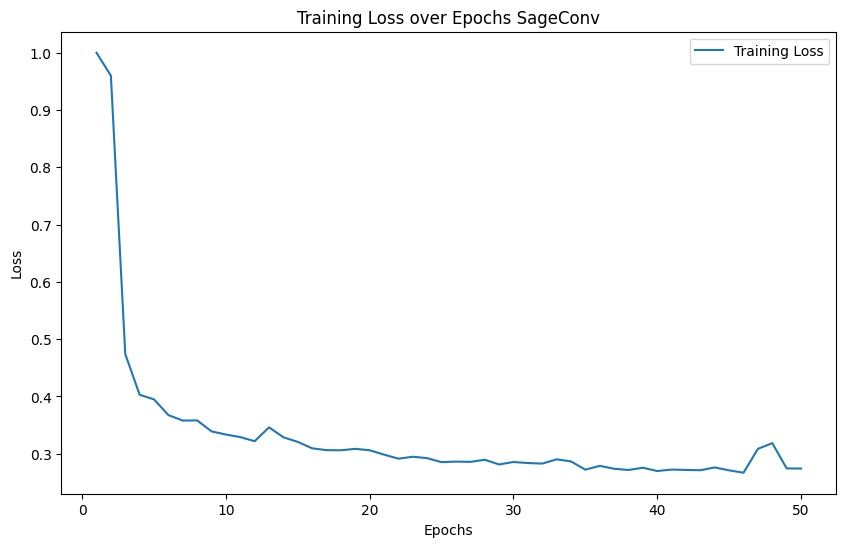

              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3163
           1       0.31      0.88      0.46       162

    accuracy                           0.90      3325
   macro avg       0.65      0.89      0.70      3325
weighted avg       0.96      0.90      0.92      3325



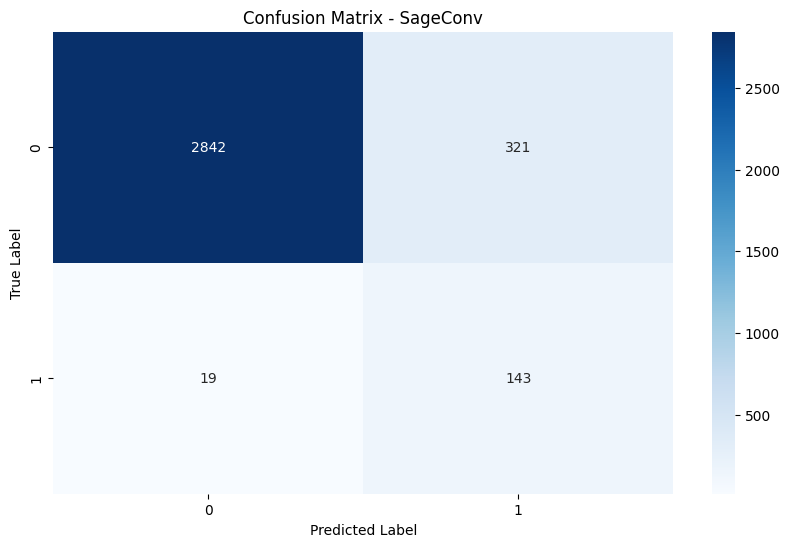

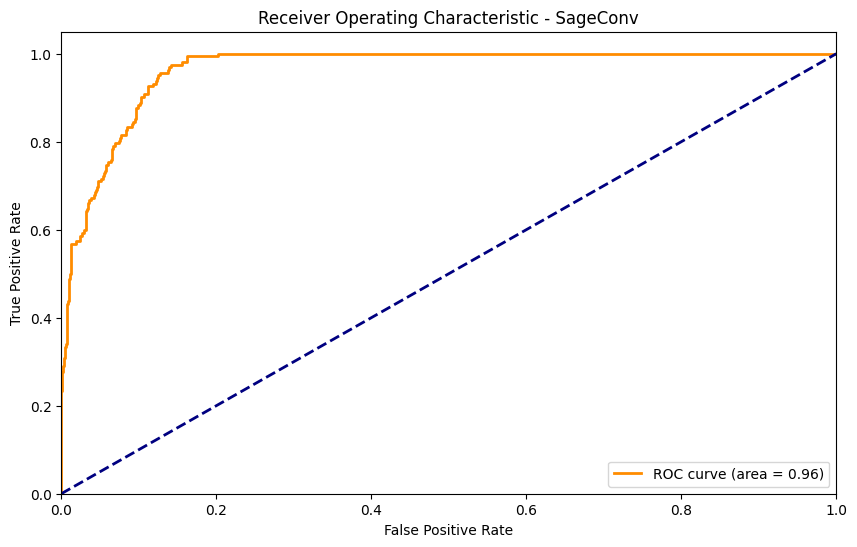

Inside train model with class weights
Epoch 1, Loss: 0.8742863918077606
Epoch 2, Loss: 0.8179777828247651
Epoch 3, Loss: 0.6115568280220032
Epoch 4, Loss: 0.5939212149899938
Epoch 5, Loss: 0.5613905631977579
Epoch 6, Loss: 0.5568807455508605
Epoch 7, Loss: 0.5419413607729517
Epoch 8, Loss: 0.5345929810858291
Epoch 9, Loss: 0.5266150893724483
Epoch 10, Loss: 0.5237688274811143
Epoch 11, Loss: 0.5224113708928876
Epoch 12, Loss: 0.5179144038778284
Epoch 13, Loss: 0.5137425261023252
Epoch 14, Loss: 0.5138796527424584
Epoch 15, Loss: 0.5070744305849075
Epoch 16, Loss: 0.5061418367144854
Epoch 17, Loss: 0.5000980470491492
Epoch 18, Loss: 0.4990937359955
Epoch 19, Loss: 0.4931136112174262
Epoch 20, Loss: 0.5167899394164914
Epoch 21, Loss: 0.4926836108383925
Epoch 22, Loss: 0.4939848079305628
Epoch 23, Loss: 0.48744408348980156
Epoch 24, Loss: 0.4904667882491713
Epoch 25, Loss: 0.4844845965828585
Epoch 26, Loss: 0.4859403838282046
Epoch 27, Loss: 0.4822916722168093
Epoch 28, Loss: 0.4801998540

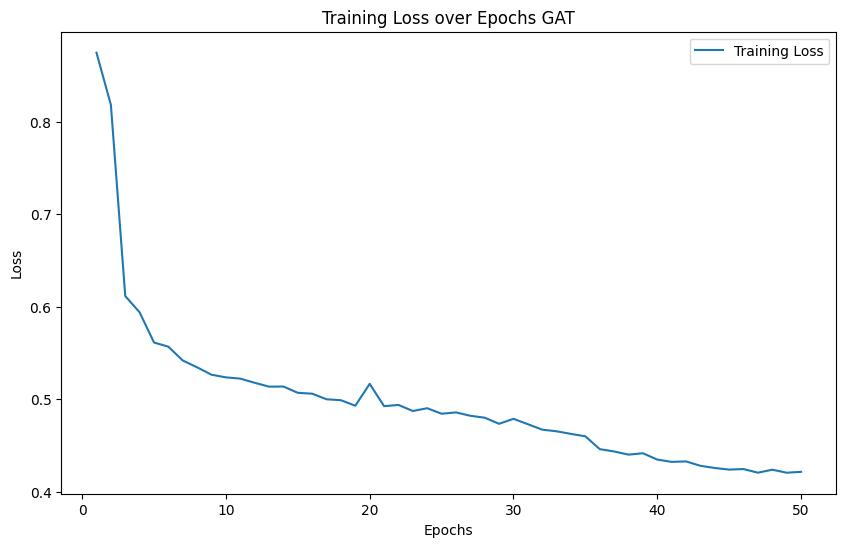

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3163
           1       0.37      0.40      0.38       162

    accuracy                           0.94      3325
   macro avg       0.67      0.68      0.67      3325
weighted avg       0.94      0.94      0.94      3325



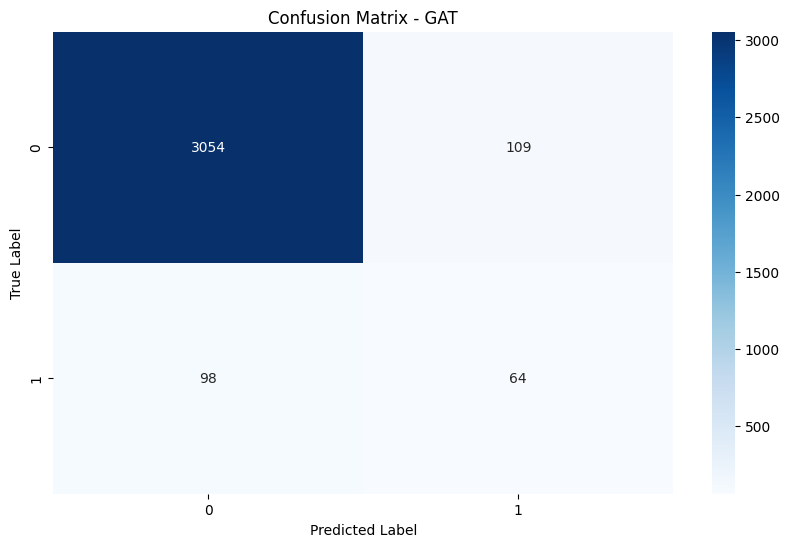

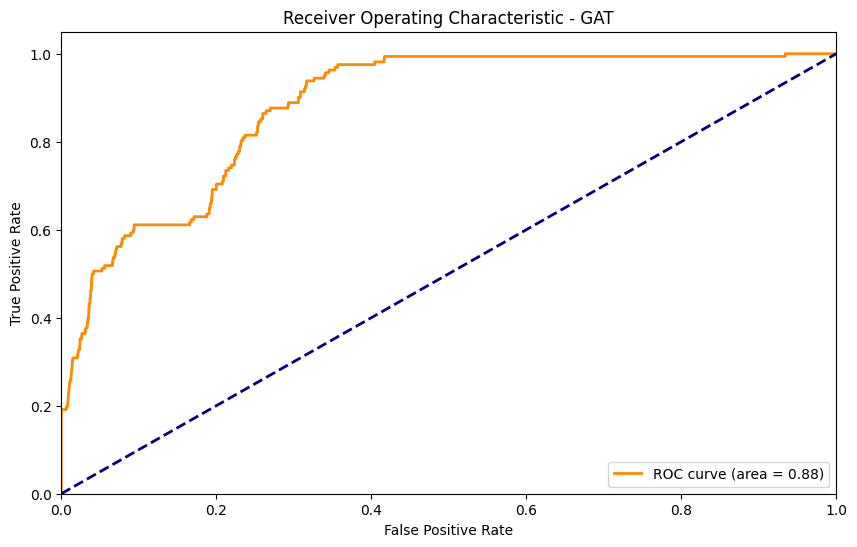

Inside train model with class weights
Epoch 1, Loss: 1.1260907356949958
Epoch 2, Loss: 1.1301178250502308
Epoch 3, Loss: 0.4818311568511569
Epoch 4, Loss: 0.410764429718256
Epoch 5, Loss: 0.3776818057117255
Epoch 6, Loss: 0.3645233392067578
Epoch 7, Loss: 0.3455224223434925
Epoch 8, Loss: 0.3402954783776532
Epoch 9, Loss: 0.3348513530648273
Epoch 10, Loss: 0.3208979238634524
Epoch 11, Loss: 0.3102465252513471
Epoch 12, Loss: 0.3039349393676157
Epoch 13, Loss: 0.30947643664220104
Epoch 14, Loss: 0.2972525112006975
Epoch 15, Loss: 0.30587986646139104
Epoch 16, Loss: 0.2949567354567673
Epoch 17, Loss: 0.29850835774255835
Epoch 18, Loss: 0.2878128474821215
Epoch 19, Loss: 0.31215376844224724
Epoch 20, Loss: 0.29143881635821384
Epoch 21, Loss: 0.2932328955958719
Epoch 22, Loss: 0.2783358754671138
Epoch 23, Loss: 0.2848009640431922
Epoch 24, Loss: 0.28577093828631484
Epoch 25, Loss: 0.2856558166120363
Epoch 26, Loss: 0.27364191688273265
Epoch 27, Loss: 0.28182810107650963
Epoch 28, Loss: 0.2

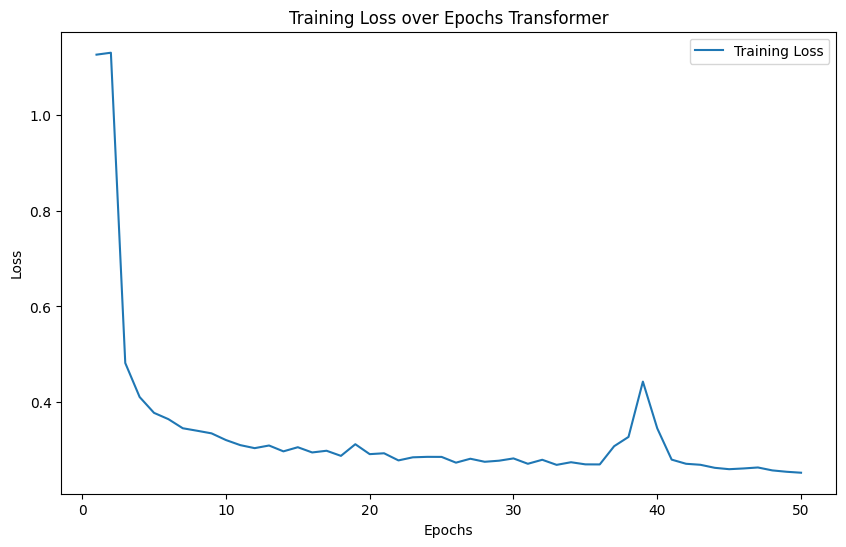

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      3163
           1       0.32      0.82      0.46       162

    accuracy                           0.91      3325
   macro avg       0.65      0.87      0.70      3325
weighted avg       0.96      0.91      0.92      3325



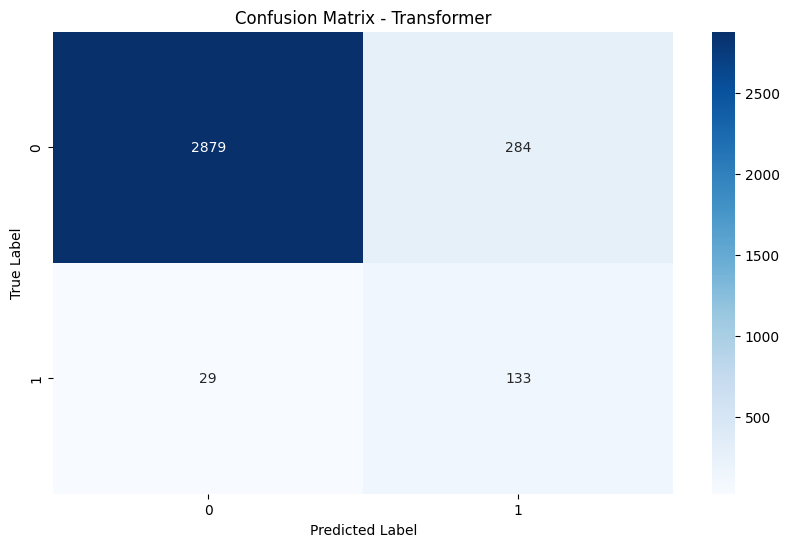

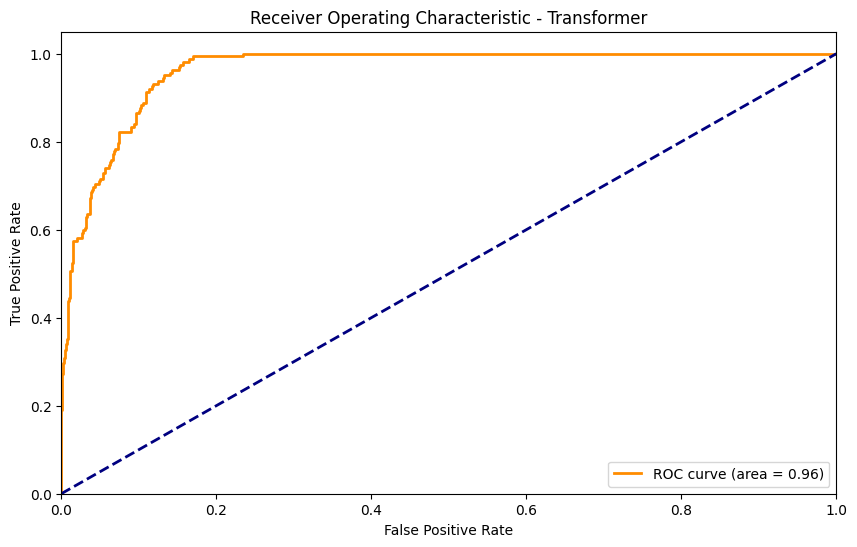

Inside train model with class weights
Epoch 1, Loss: 1.1221643440911304
Epoch 2, Loss: 0.748895579058191
Epoch 3, Loss: 0.6620739225460135
Epoch 4, Loss: 0.636602011711701
Epoch 5, Loss: 0.6336358539436174
Epoch 6, Loss: 0.6155696789855543
Epoch 7, Loss: 0.5937695302393126
Epoch 8, Loss: 0.5817922373180804
Epoch 9, Loss: 0.5757836343153663
Epoch 10, Loss: 0.5698830890266792
Epoch 11, Loss: 0.5615514766262926
Epoch 12, Loss: 0.5569147866057313
Epoch 13, Loss: 0.5476624638490055
Epoch 14, Loss: 0.545284384942573
Epoch 15, Loss: 0.5388114909115045
Epoch 16, Loss: 0.5343009628679442
Epoch 17, Loss: 0.5273368556214415
Epoch 18, Loss: 0.5249517219869987
Epoch 19, Loss: 0.5206621846427089
Epoch 20, Loss: 0.5192591224027716
Epoch 21, Loss: 0.5175399242535882
Epoch 22, Loss: 0.5102468550853108
Epoch 23, Loss: 0.5093174806755522
Epoch 24, Loss: 0.5103588774800301
Epoch 25, Loss: 0.5096460933918538
Epoch 26, Loss: 0.5050726996167846
Epoch 27, Loss: 0.5071003106625184
Epoch 28, Loss: 0.50331710343

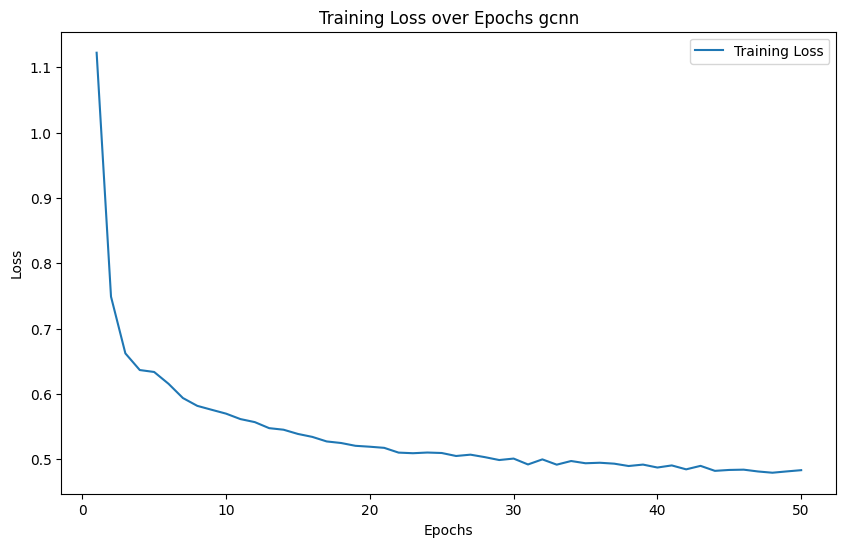

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3163
           1       0.46      0.46      0.46       162

    accuracy                           0.95      3325
   macro avg       0.72      0.72      0.72      3325
weighted avg       0.95      0.95      0.95      3325



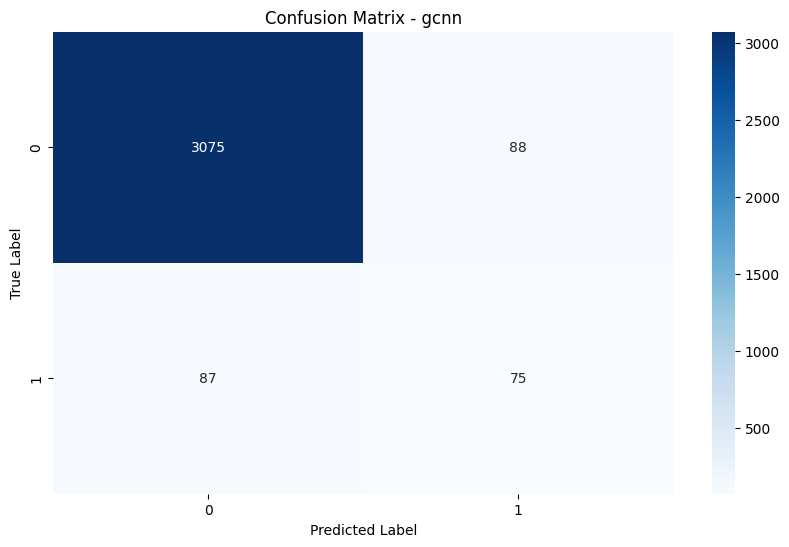

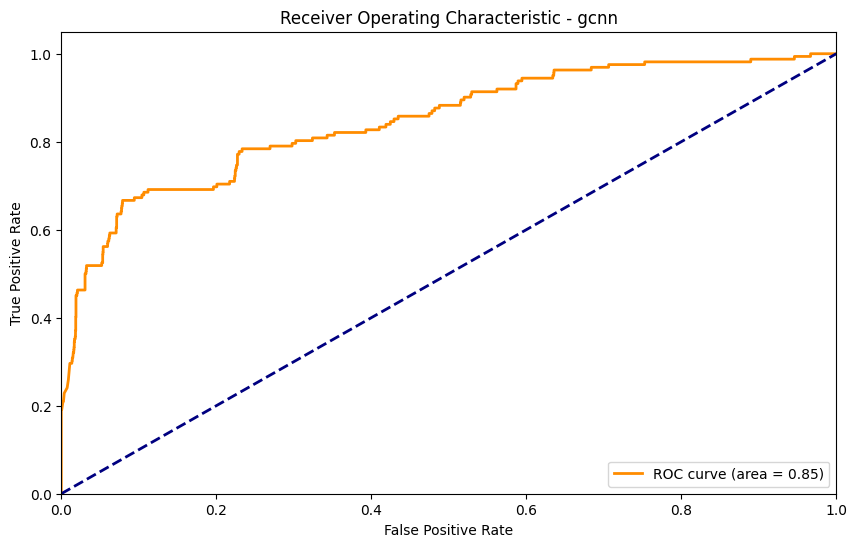

{'type10_label': {'GSageConv': 0.8977443609022556, 'GAT': 0.9377443609022557, 'GTransformer': 0.9058646616541354, 'GCNN': 0.9473684210526315}}
type1_label_


100%|██████████| 2079/2079 [00:31<00:00, 65.92it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1455
test_data:624
Inside train model with class weights
Epoch 1, Loss: 0.8091313028100716
Epoch 2, Loss: 0.23655843540378238
Epoch 3, Loss: 0.17021929351208004
Epoch 4, Loss: 0.14254230106978313
Epoch 5, Loss: 0.129911580365961
Epoch 6, Loss: 0.128055426373106
Epoch 7, Loss: 0.1100493531431193
Epoch 8, Loss: 0.11322941898327807
Epoch 9, Loss: 0.10498473412640717
Epoch 10, Loss: 0.10201408151213241
Epoch 11, Loss: 0.09082103876963905
Epoch 12, Loss: 0.0973332317384041
Epoch 13, Loss: 0.09234366596311978
Epoch 14, Loss: 0.08706239614959645
Epoch 15, Loss: 0.08923777456030897
Epoch 16, Loss: 0.08983057857815015
Epoch 17, Loss: 0.08496351710156254
Epoch 18, Loss: 0.08266206103903444
Epoch 19, Loss: 0.07450234568070459
Epoch 20, Loss: 0.07818189016340868
Epoch 21, Loss: 0.07565625230579273
Epoch 22, Loss: 0.07242422285692199
Epoch 23, Loss: 0.0714233811215862
Epoch 24, Loss: 0.07834422323123916
Epoch 25, Loss: 0.06400928077409448
Epoch 26, Loss: 0.06741626935241662
Epoch 27, Los

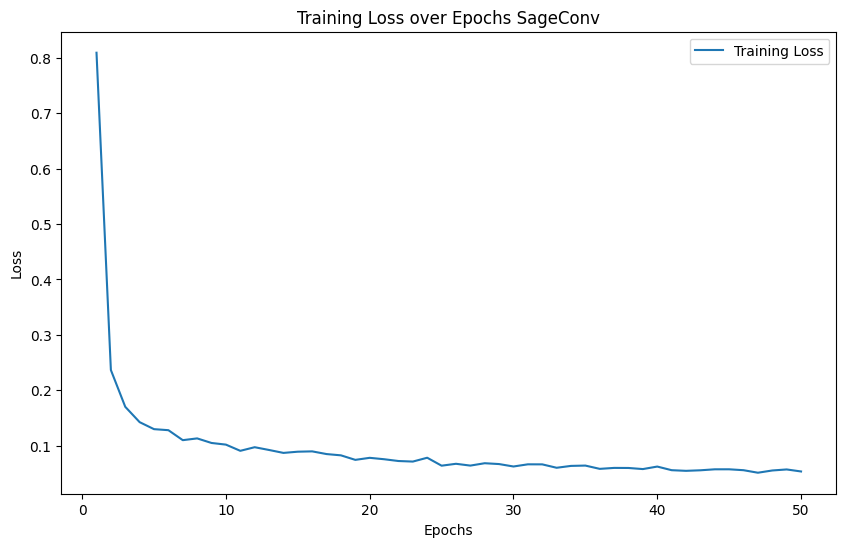

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1128
           1       0.91      1.00      0.95       509

    accuracy                           0.97      1637
   macro avg       0.95      0.98      0.96      1637
weighted avg       0.97      0.97      0.97      1637



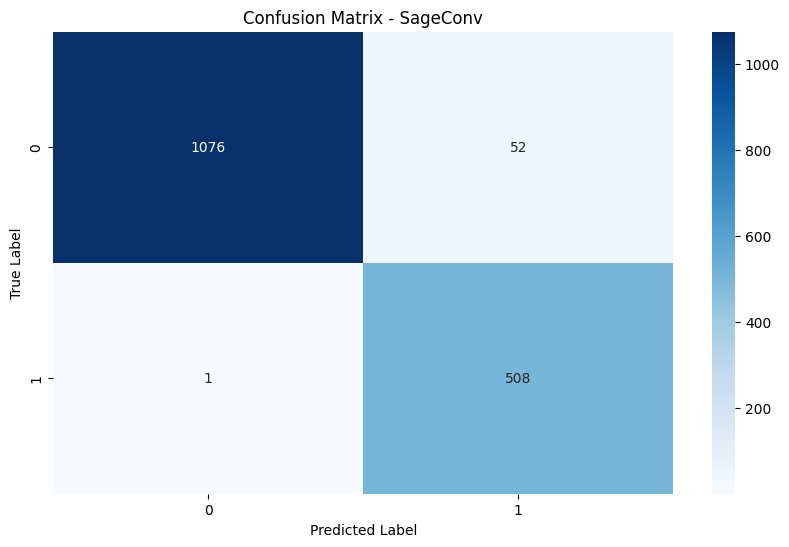

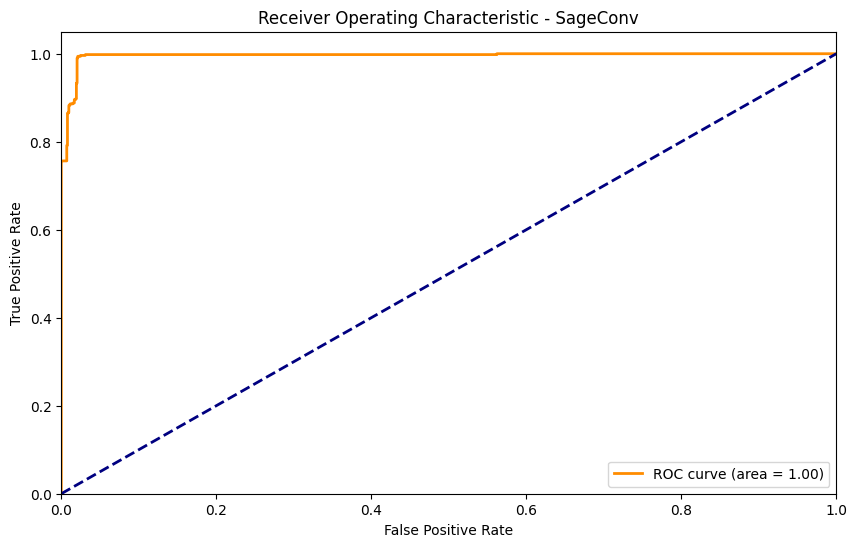

Inside train model with class weights
Epoch 1, Loss: 0.6339679470528727
Epoch 2, Loss: 0.4051719975212346
Epoch 3, Loss: 0.3339793408370536
Epoch 4, Loss: 0.3212480626028517
Epoch 5, Loss: 0.31122257236553275
Epoch 6, Loss: 0.31145460207177245
Epoch 7, Loss: 0.30761568556013313
Epoch 8, Loss: 0.3039043987898723
Epoch 9, Loss: 0.2995117619309736
Epoch 10, Loss: 0.2977004062546336
Epoch 11, Loss: 0.29527963309184363
Epoch 12, Loss: 0.29508230640836386
Epoch 13, Loss: 0.29418506376121356
Epoch 14, Loss: 0.2901148590380731
Epoch 15, Loss: 0.28706100842227106
Epoch 16, Loss: 0.2861968985070353
Epoch 17, Loss: 0.28081824322757515
Epoch 18, Loss: 0.2794274747695612
Epoch 19, Loss: 0.27838238409679866
Epoch 20, Loss: 0.2697254626647286
Epoch 21, Loss: 0.2622157477814218
Epoch 22, Loss: 0.2623856524410455
Epoch 23, Loss: 0.26185648564411246
Epoch 24, Loss: 0.25929129204672313
Epoch 25, Loss: 0.2597501099757526
Epoch 26, Loss: 0.2571212612092495
Epoch 27, Loss: 0.2574572467609592
Epoch 28, Loss:

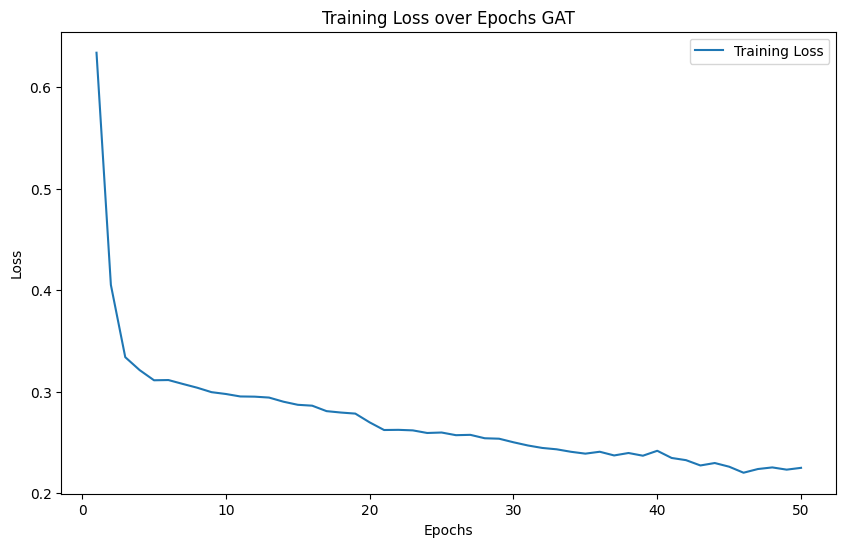

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      1128
           1       0.67      0.94      0.79       509

    accuracy                           0.84      1637
   macro avg       0.82      0.87      0.83      1637
weighted avg       0.88      0.84      0.85      1637



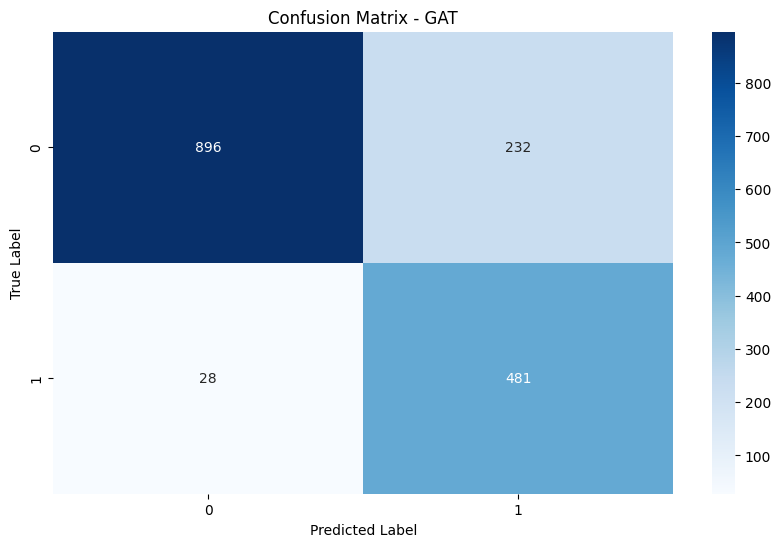

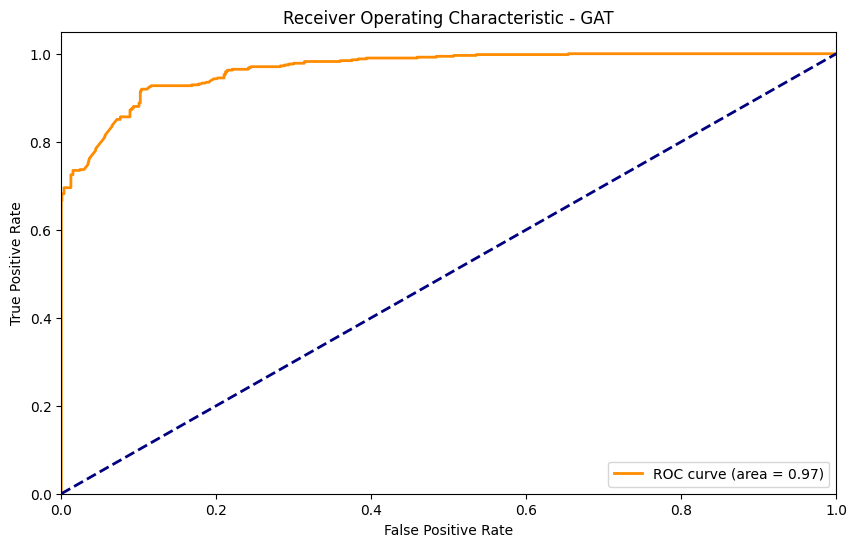

Inside train model with class weights
Epoch 1, Loss: 0.7781989437163525
Epoch 2, Loss: 0.2352344835905925
Epoch 3, Loss: 0.1591244025722794
Epoch 4, Loss: 0.14491269923746586
Epoch 5, Loss: 0.1315693092815902
Epoch 6, Loss: 0.11862703663823397
Epoch 7, Loss: 0.12539141637313625
Epoch 8, Loss: 0.1202377314152925
Epoch 9, Loss: 0.11307523045283945
Epoch 10, Loss: 0.10228427932800158
Epoch 11, Loss: 0.09230525170088462
Epoch 12, Loss: 0.0954074819734239
Epoch 13, Loss: 0.08801906472881851
Epoch 14, Loss: 0.08771373977398743
Epoch 15, Loss: 0.09109202938397294
Epoch 16, Loss: 0.08650311649493549
Epoch 17, Loss: 0.08150597805481243
Epoch 18, Loss: 0.07645203136717496
Epoch 19, Loss: 0.0827871234682591
Epoch 20, Loss: 0.0816078620314922
Epoch 21, Loss: 0.0720792486048911
Epoch 22, Loss: 0.06581255243888692
Epoch 23, Loss: 0.07381145759364185
Epoch 24, Loss: 0.07008739174141185
Epoch 25, Loss: 0.06842155837575378
Epoch 26, Loss: 0.06541153849305018
Epoch 27, Loss: 0.06953560919298427
Epoch 28

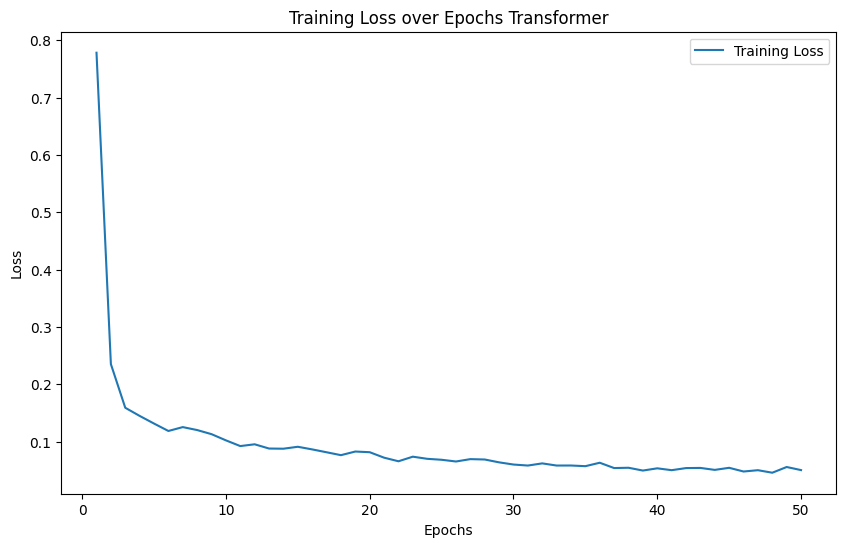

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1128
           1       0.92      1.00      0.96       509

    accuracy                           0.97      1637
   macro avg       0.96      0.98      0.97      1637
weighted avg       0.98      0.97      0.97      1637



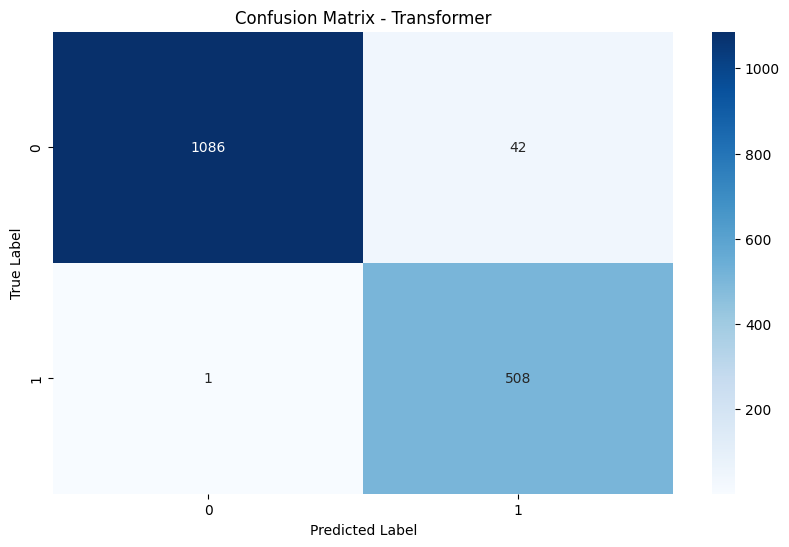

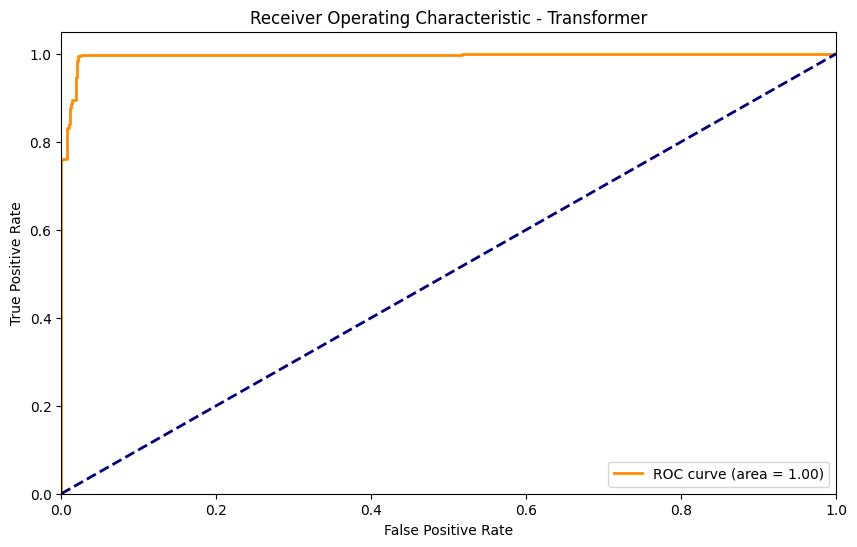

Inside train model with class weights
Epoch 1, Loss: 0.663018532421278
Epoch 2, Loss: 0.42410521986691846
Epoch 3, Loss: 0.35483995922233746
Epoch 4, Loss: 0.34819996324570285
Epoch 5, Loss: 0.34004936594030133
Epoch 6, Loss: 0.33647228874590085
Epoch 7, Loss: 0.3309129965694054
Epoch 8, Loss: 0.3295063859094744
Epoch 9, Loss: 0.3268289647024611
Epoch 10, Loss: 0.3215623935279639
Epoch 11, Loss: 0.3220806073235429
Epoch 12, Loss: 0.3169694205989008
Epoch 13, Loss: 0.3149075086997903
Epoch 14, Loss: 0.31324743835822394
Epoch 15, Loss: 0.31191253597321716
Epoch 16, Loss: 0.31017669840999273
Epoch 17, Loss: 0.3103407261812169
Epoch 18, Loss: 0.307166674538799
Epoch 19, Loss: 0.3038989441550296
Epoch 20, Loss: 0.3032853460830191
Epoch 21, Loss: 0.3037111736510111
Epoch 22, Loss: 0.301313315882631
Epoch 23, Loss: 0.2977295974674432
Epoch 24, Loss: 0.29908662483744
Epoch 25, Loss: 0.29639229680532997
Epoch 26, Loss: 0.29489289434707683
Epoch 27, Loss: 0.29235283447348553
Epoch 28, Loss: 0.29

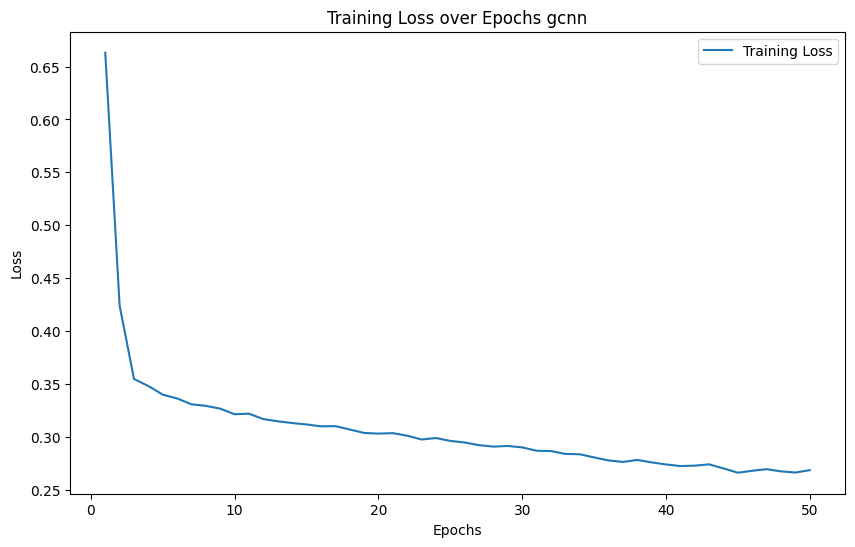

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1128
           1       0.75      0.92      0.83       509

    accuracy                           0.88      1637
   macro avg       0.86      0.89      0.87      1637
weighted avg       0.90      0.88      0.89      1637



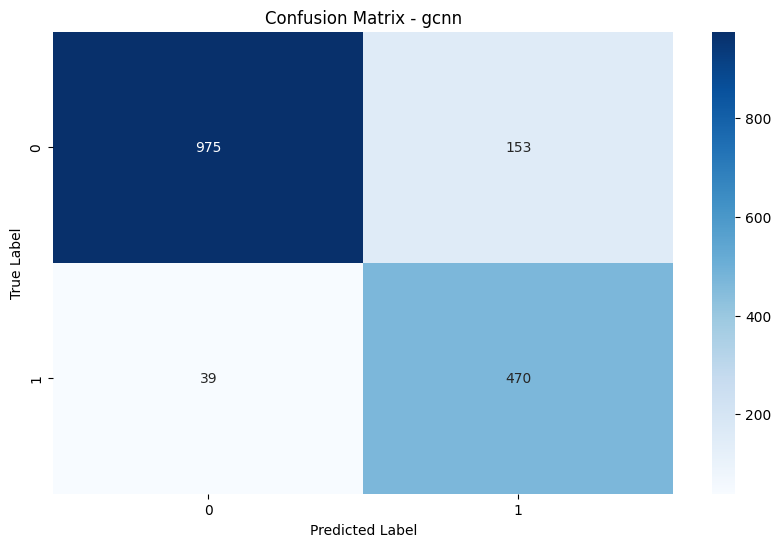

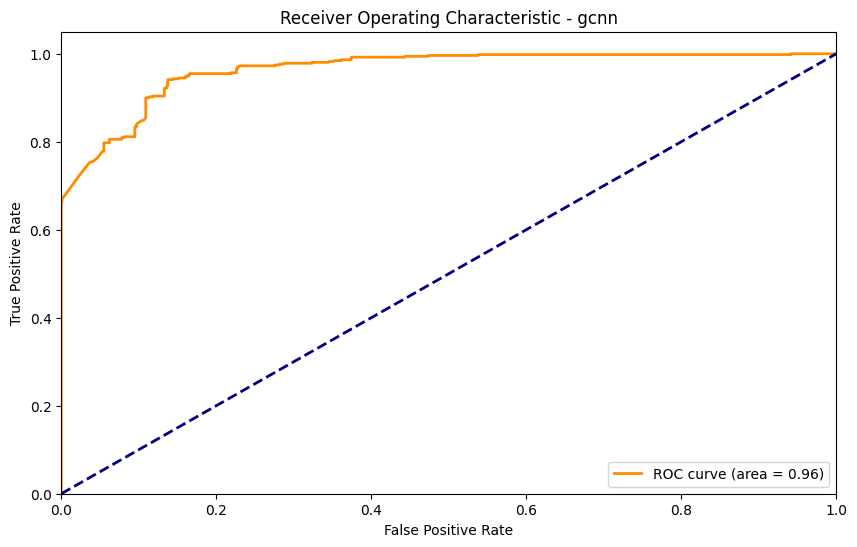

{'type10_label': {'GSageConv': 0.8977443609022556, 'GAT': 0.9377443609022557, 'GTransformer': 0.9058646616541354, 'GCNN': 0.9473684210526315}, 'type1_label_': {'GSageConv': 0.967623701893708, 'GAT': 0.8411728772144166, 'GTransformer': 0.9737324373854612, 'GCNN': 0.8827122785583384}}
type2_label_


100%|██████████| 1342/1342 [00:21<00:00, 61.42it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:939
test_data:403
Inside train model with class weights
Epoch 1, Loss: 0.6709380680695176
Epoch 2, Loss: 0.4084036309272051
Epoch 3, Loss: 0.3765153361794849
Epoch 4, Loss: 0.23540443821499746
Epoch 5, Loss: 0.26409444731349746
Epoch 6, Loss: 0.22934843978534142
Epoch 7, Loss: 0.15491028213873506
Epoch 8, Loss: 0.11519222607215246
Epoch 9, Loss: 0.2245438482767592
Epoch 10, Loss: 0.10134850243727365
Epoch 11, Loss: 0.1582766953545312
Epoch 12, Loss: 0.16230544146771234
Epoch 13, Loss: 0.08067362625151872
Epoch 14, Loss: 0.04764069613690178
Epoch 15, Loss: 0.10584859059502681
Epoch 16, Loss: 0.056766245521915455
Epoch 17, Loss: 0.05880339665648838
Epoch 18, Loss: 0.09018756672739983
Epoch 19, Loss: 0.03393769900624951
Epoch 20, Loss: 0.08093854576194039
Epoch 21, Loss: 0.054137193427110715
Epoch 22, Loss: 0.16839324890170246
Epoch 23, Loss: 0.13893859426801403
Epoch 24, Loss: 0.1133058846462518
Epoch 25, Loss: 0.036552072898484764
Epoch 26, Loss: 0.08103936919166396
Epoch 27,

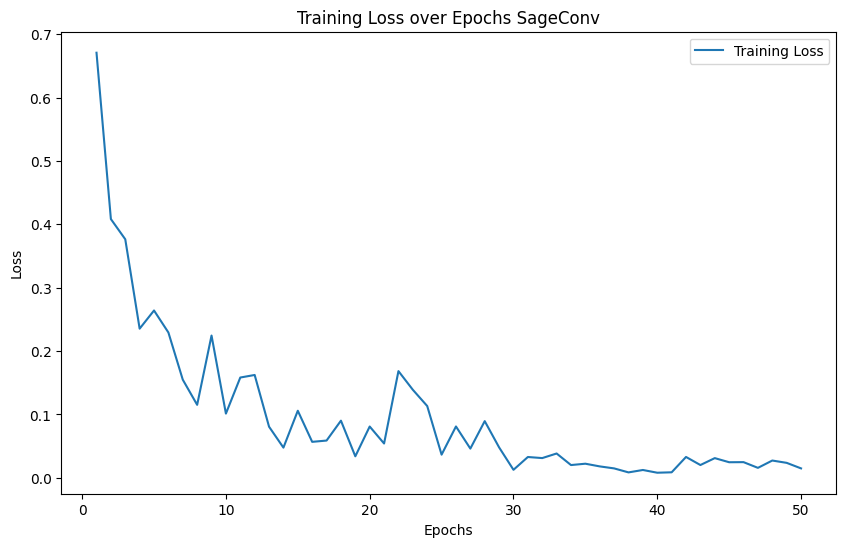

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.50      1.00      0.67         4

    accuracy                           1.00      1986
   macro avg       0.75      1.00      0.83      1986
weighted avg       1.00      1.00      1.00      1986



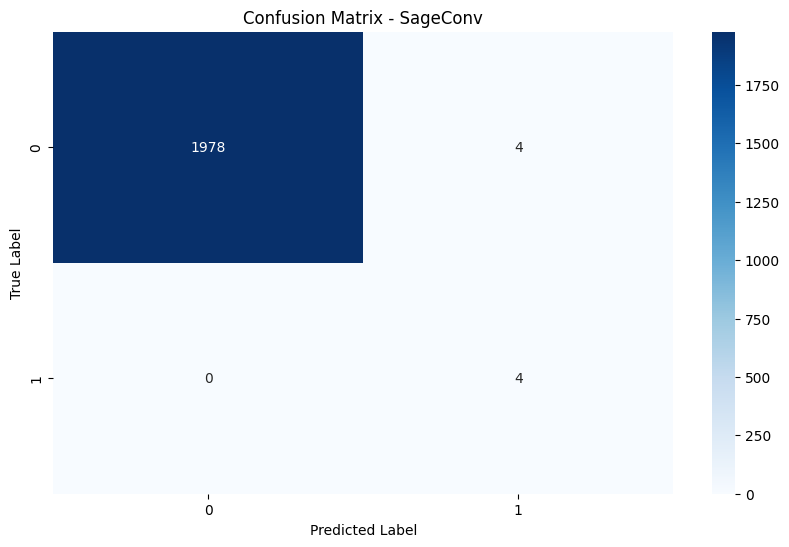

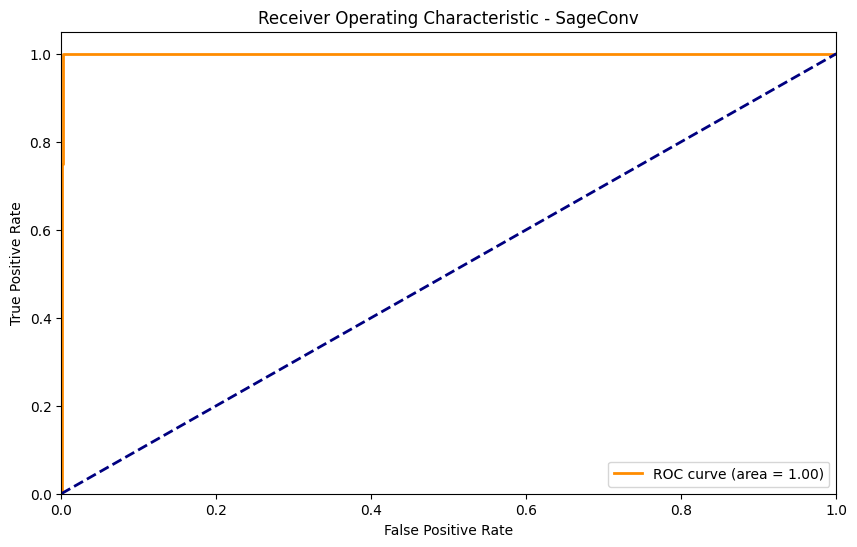

Inside train model with class weights
Epoch 1, Loss: 0.527179661517342
Epoch 2, Loss: 0.30289777790506683
Epoch 3, Loss: 0.22084646075963973
Epoch 4, Loss: 0.24231305085122584
Epoch 5, Loss: 0.2343803633004427
Epoch 6, Loss: 0.21762403286993504
Epoch 7, Loss: 0.2005630273371935
Epoch 8, Loss: 0.27380894143134354
Epoch 9, Loss: 0.21693530790507792
Epoch 10, Loss: 0.20497958001991112
Epoch 11, Loss: 0.22662161601086458
Epoch 12, Loss: 0.19703716225922108
Epoch 13, Loss: 0.22853201776742935
Epoch 14, Loss: 0.18908381797373294
Epoch 15, Loss: 0.2588065588846803
Epoch 16, Loss: 0.19874923365811506
Epoch 17, Loss: 0.24471491860846678
Epoch 18, Loss: 0.2326767800996701
Epoch 19, Loss: 0.18982576311876376
Epoch 20, Loss: 0.21184866248319548
Epoch 21, Loss: 0.21134393215179442
Epoch 22, Loss: 0.17185797579586506
Epoch 23, Loss: 0.20031523530681927
Epoch 24, Loss: 0.17845503569891055
Epoch 25, Loss: 0.14891313686966895
Epoch 26, Loss: 0.15997016932815314
Epoch 27, Loss: 0.16681927169362704
Epoch

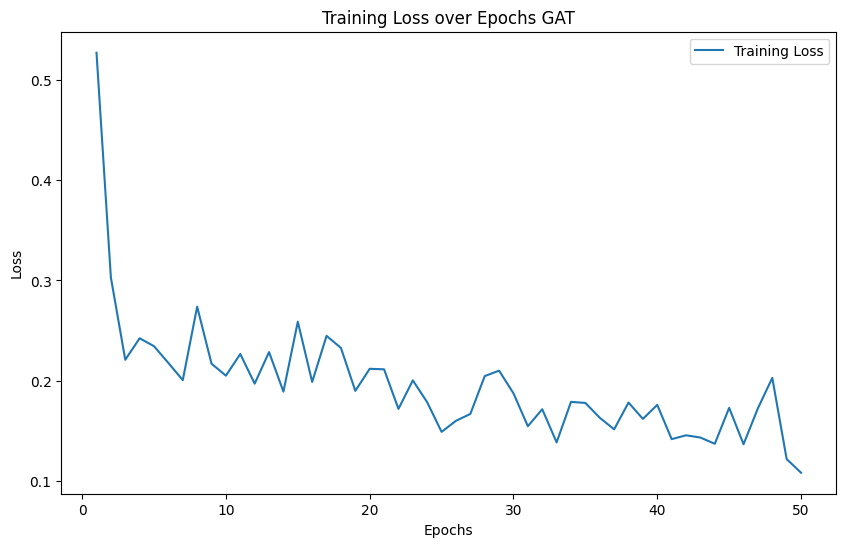

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1986
   macro avg       0.50      0.50      0.50      1986
weighted avg       1.00      1.00      1.00      1986



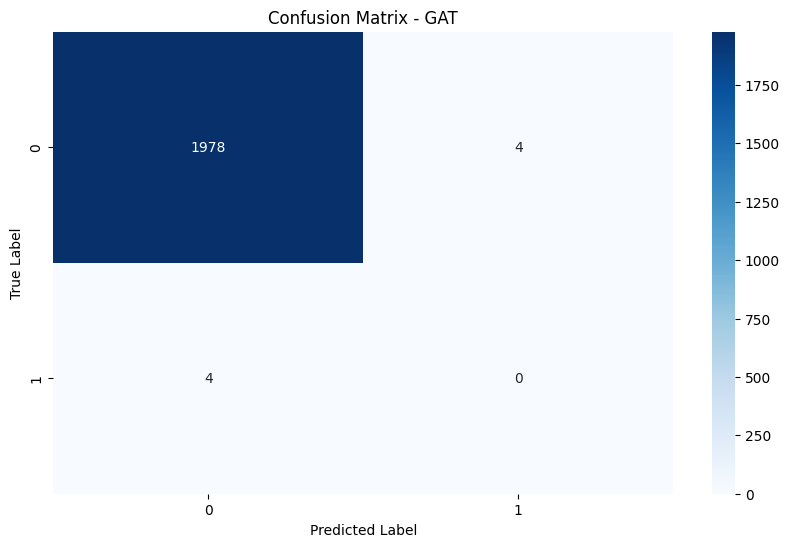

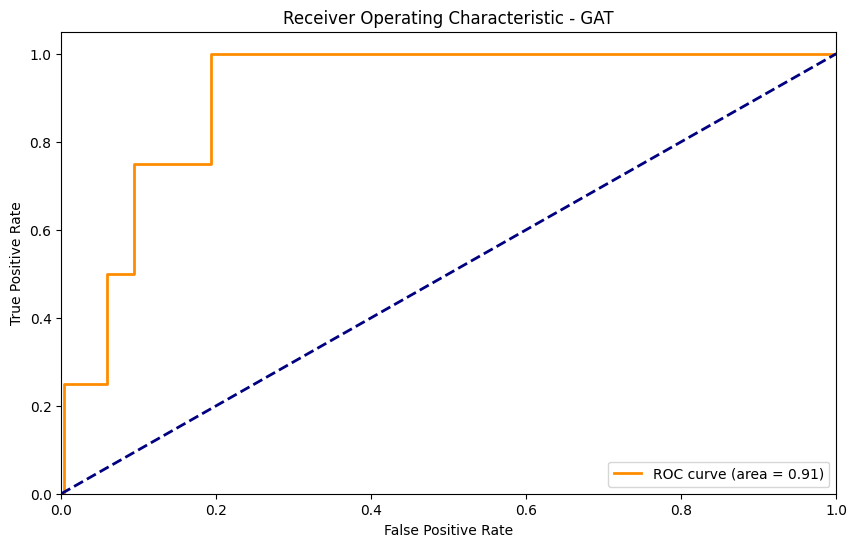

Inside train model with class weights
Epoch 1, Loss: 0.7369229234832649
Epoch 2, Loss: 0.31639281059615315
Epoch 3, Loss: 0.35063860469187297
Epoch 4, Loss: 0.19399291137233377
Epoch 5, Loss: 0.3483706467008839
Epoch 6, Loss: 0.2900752093022068
Epoch 7, Loss: 0.2596242270432413
Epoch 8, Loss: 0.11901467144489289
Epoch 9, Loss: 0.16815266978616517
Epoch 10, Loss: 0.19087810534983873
Epoch 11, Loss: 0.08194664288312196
Epoch 12, Loss: 0.06590782469914605
Epoch 13, Loss: 0.046020958370839554
Epoch 14, Loss: 0.15120603188406675
Epoch 15, Loss: 0.10093587897717952
Epoch 16, Loss: 0.17423922467666367
Epoch 17, Loss: 0.05319204496530195
Epoch 18, Loss: 0.07005583799909801
Epoch 19, Loss: 0.04310824084095657
Epoch 20, Loss: 0.08486576090411593
Epoch 21, Loss: 0.05002921647392213
Epoch 22, Loss: 0.040736795587387555
Epoch 23, Loss: 0.04807918599496285
Epoch 24, Loss: 0.03733490818801025
Epoch 25, Loss: 0.02380043799833705
Epoch 26, Loss: 0.020208889700006692
Epoch 27, Loss: 0.04399476675122666


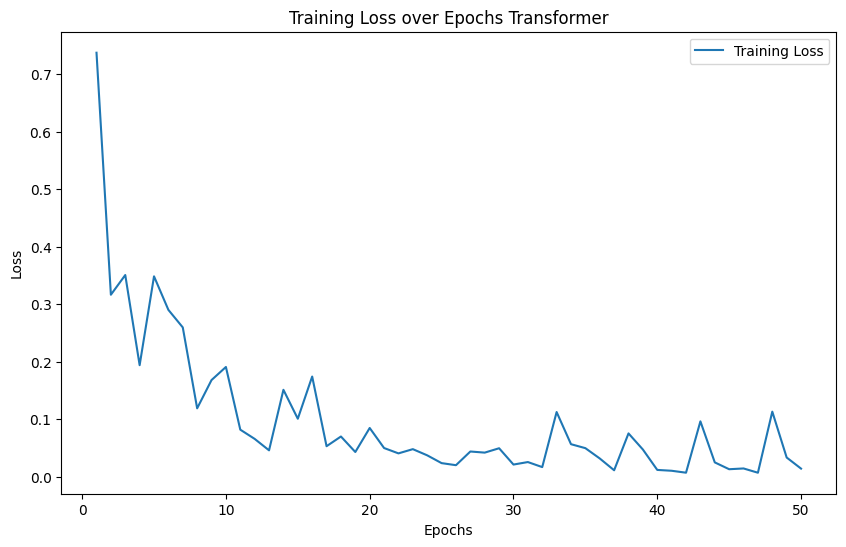

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.38      0.75      0.50         4

    accuracy                           1.00      1986
   macro avg       0.69      0.87      0.75      1986
weighted avg       1.00      1.00      1.00      1986



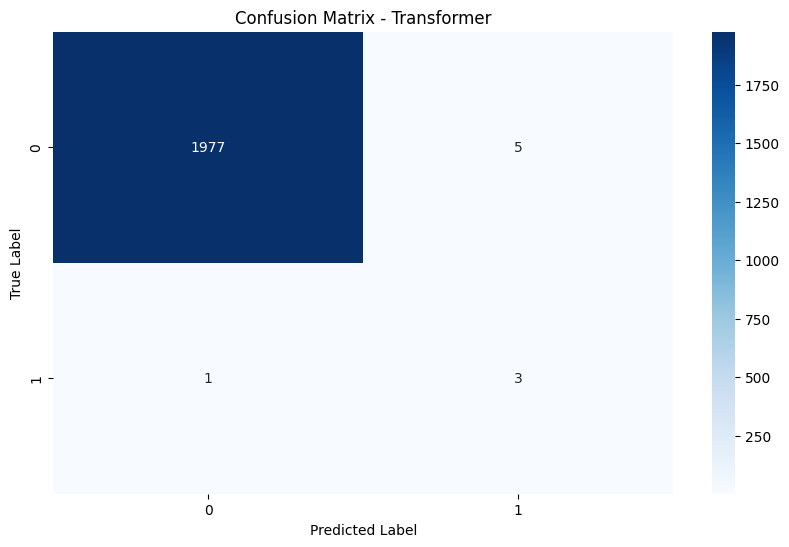

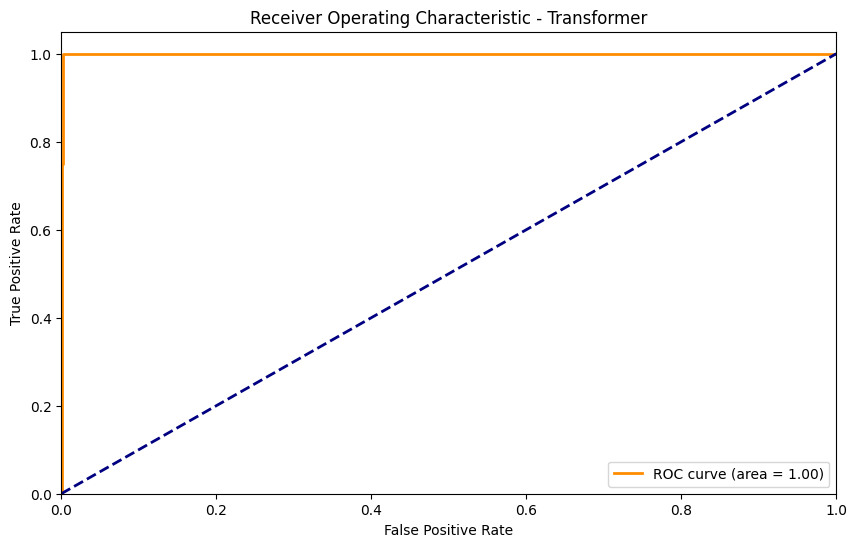

Inside train model with class weights
Epoch 1, Loss: 0.4169002071333428
Epoch 2, Loss: 0.25376771595329045
Epoch 3, Loss: 0.28039252422749994
Epoch 4, Loss: 0.23180420783658823
Epoch 5, Loss: 0.2697632455577453
Epoch 6, Loss: 0.2890871139864127
Epoch 7, Loss: 0.23436096645891666
Epoch 8, Loss: 0.23279206939041613
Epoch 9, Loss: 0.23376830617586772
Epoch 10, Loss: 0.2195116834094127
Epoch 11, Loss: 0.24214930000404516
Epoch 12, Loss: 0.2509061944981416
Epoch 13, Loss: 0.21571199260652066
Epoch 14, Loss: 0.23583482299000025
Epoch 15, Loss: 0.24297560639679433
Epoch 16, Loss: 0.22701172033945718
Epoch 17, Loss: 0.2186996167525649
Epoch 18, Loss: 0.2034221972649296
Epoch 19, Loss: 0.17987948625038067
Epoch 20, Loss: 0.204732404773434
Epoch 21, Loss: 0.2295028928667307
Epoch 22, Loss: 0.19140419140458106
Epoch 23, Loss: 0.1952076811964313
Epoch 24, Loss: 0.18665426218261322
Epoch 25, Loss: 0.21763338757057984
Epoch 26, Loss: 0.18739682883024217
Epoch 27, Loss: 0.17832699877520403
Epoch 28, 

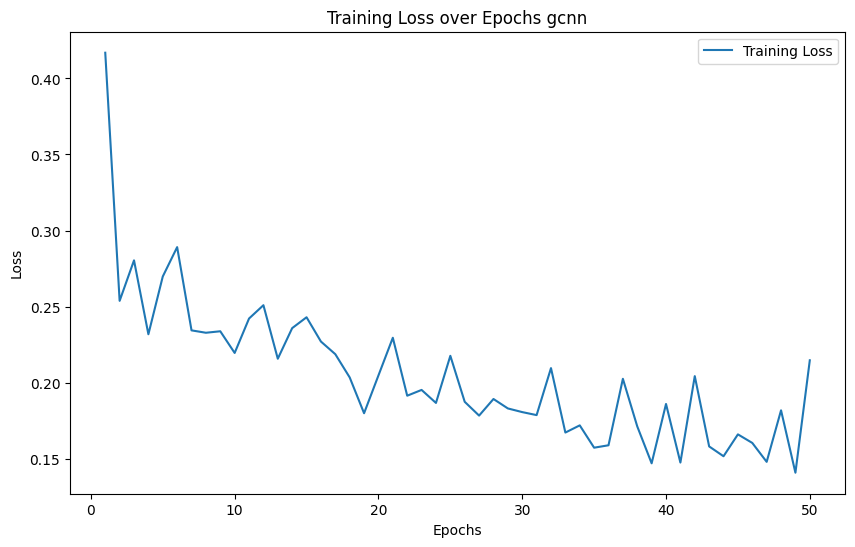

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1982
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1986
   macro avg       0.50      0.50      0.50      1986
weighted avg       1.00      1.00      1.00      1986



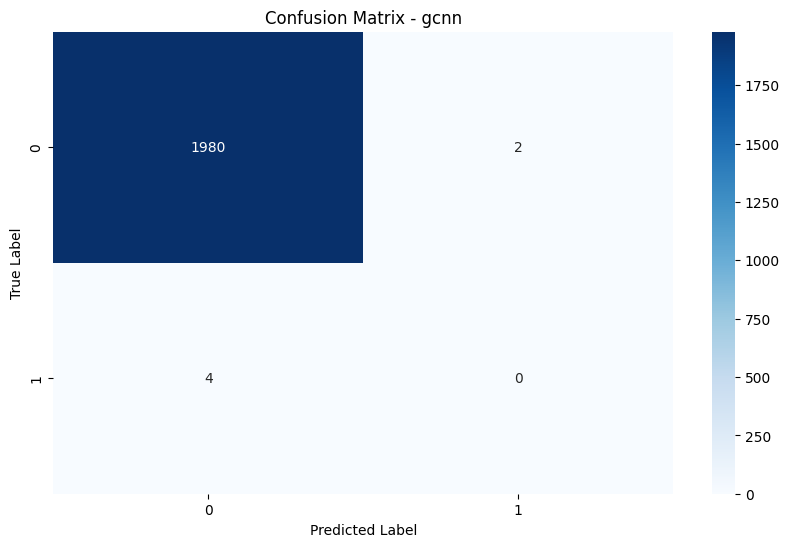

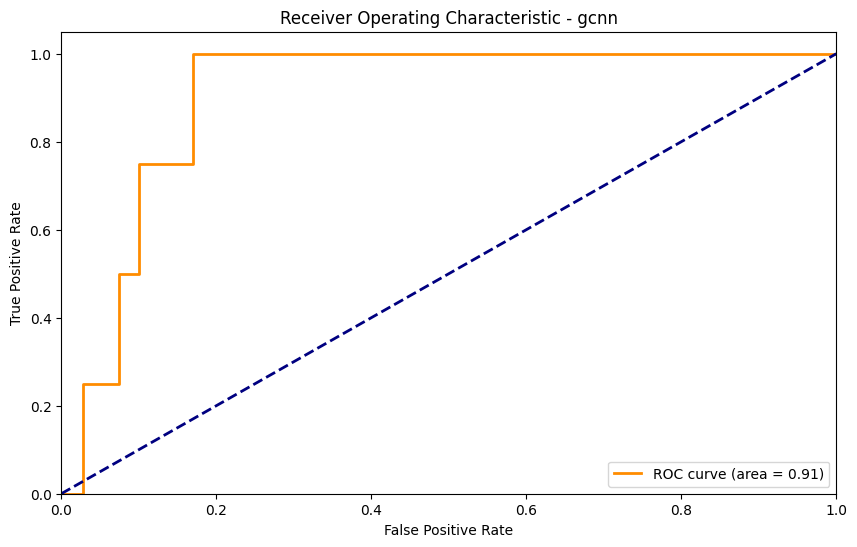

{'type10_label': {'GSageConv': 0.8977443609022556, 'GAT': 0.9377443609022557, 'GTransformer': 0.9058646616541354, 'GCNN': 0.9473684210526315}, 'type1_label_': {'GSageConv': 0.967623701893708, 'GAT': 0.8411728772144166, 'GTransformer': 0.9737324373854612, 'GCNN': 0.8827122785583384}, 'type2_label_': {'GSageConv': 0.9979859013091642, 'GAT': 0.9959718026183283, 'GTransformer': 0.9969788519637462, 'GCNN': 0.9969788519637462}}
type3_label_


100%|██████████| 1975/1975 [00:30<00:00, 63.94it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:1382
test_data:593
Inside train model with class weights
Epoch 1, Loss: 0.9405911441638388
Epoch 2, Loss: 0.3505703407255086
Epoch 3, Loss: 0.2537625069645318
Epoch 4, Loss: 0.21742968599904666
Epoch 5, Loss: 0.20037952895191583
Epoch 6, Loss: 0.19497671672566372
Epoch 7, Loss: 0.19030262978578155
Epoch 8, Loss: 0.174863733520562
Epoch 9, Loss: 0.16563795100558887
Epoch 10, Loss: 0.15316236912357536
Epoch 11, Loss: 0.15028337931091135
Epoch 12, Loss: 0.15030318032950163
Epoch 13, Loss: 0.13983986619859934
Epoch 14, Loss: 0.1371603850275278
Epoch 15, Loss: 0.13078539467162706
Epoch 16, Loss: 0.13228669432415205
Epoch 17, Loss: 0.1230247403410348
Epoch 18, Loss: 0.12975665224208074
Epoch 19, Loss: 0.12020566630896858
Epoch 20, Loss: 0.11773823455653408
Epoch 21, Loss: 0.11288531543686986
Epoch 22, Loss: 0.11217137388038365
Epoch 23, Loss: 0.11322573592505333
Epoch 24, Loss: 0.10409420332871377
Epoch 25, Loss: 0.10718321436169473
Epoch 26, Loss: 0.10501095241951672
Epoch 27, Lo

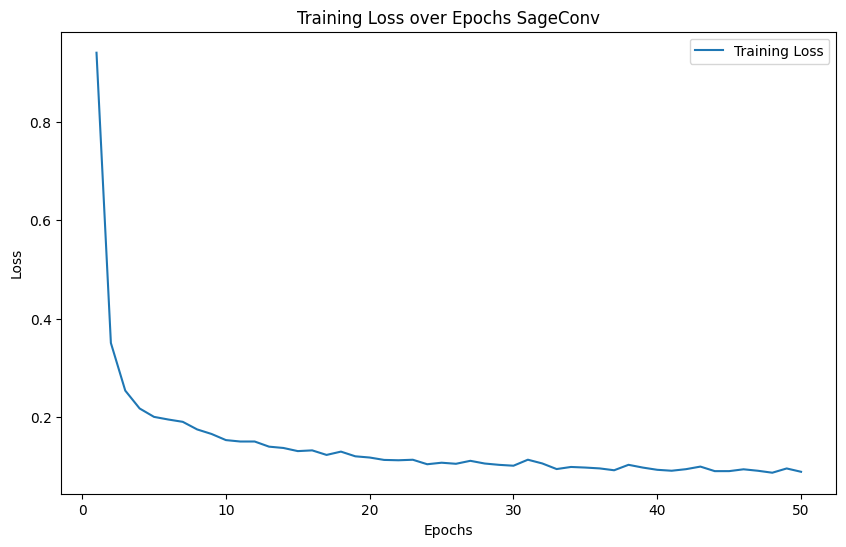

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1666
           1       0.84      0.99      0.91       479

    accuracy                           0.95      2145
   macro avg       0.92      0.97      0.94      2145
weighted avg       0.96      0.95      0.96      2145



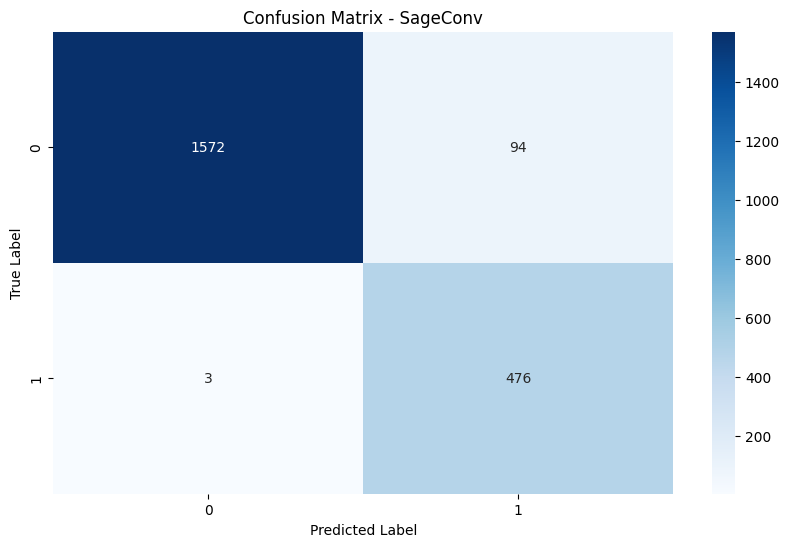

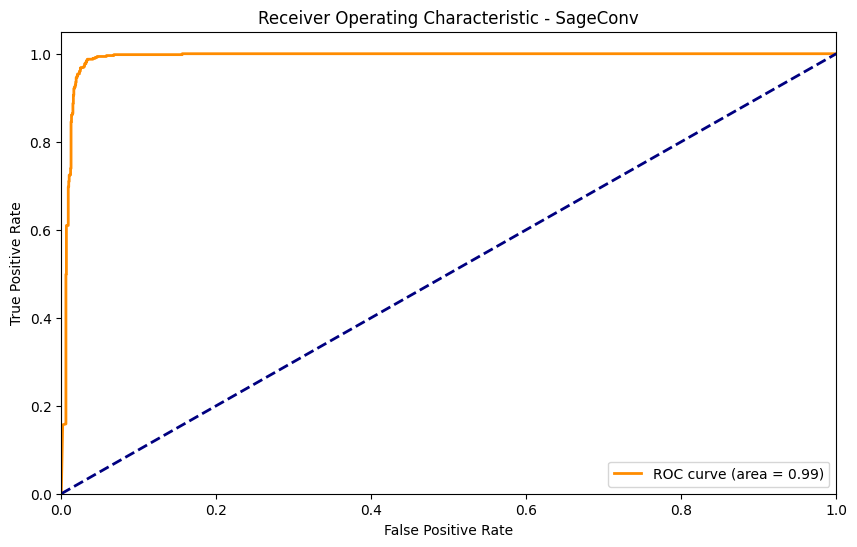

Inside train model with class weights
Epoch 1, Loss: 0.7090593603524294
Epoch 2, Loss: 0.5795517665418711
Epoch 3, Loss: 0.5241010558198799
Epoch 4, Loss: 0.5111361728473143
Epoch 5, Loss: 0.50385568798943
Epoch 6, Loss: 0.498034673996947
Epoch 7, Loss: 0.49561271173032845
Epoch 8, Loss: 0.4930144247006286
Epoch 9, Loss: 0.49063836850903253
Epoch 10, Loss: 0.48602069541811943
Epoch 11, Loss: 0.4844425618648529
Epoch 12, Loss: 0.4818457002666863
Epoch 13, Loss: 0.48015025596727023
Epoch 14, Loss: 0.47772436385804956
Epoch 15, Loss: 0.47550087896260346
Epoch 16, Loss: 0.4756961983035911
Epoch 17, Loss: 0.4717871241948821
Epoch 18, Loss: 0.4693102227015929
Epoch 19, Loss: 0.46922628818587825
Epoch 20, Loss: 0.469422536817464
Epoch 21, Loss: 0.4631761529228904
Epoch 22, Loss: 0.46214571595191956
Epoch 23, Loss: 0.4602904390882362
Epoch 24, Loss: 0.4570753581144593
Epoch 25, Loss: 0.45059028708121995
Epoch 26, Loss: 0.4513702704147859
Epoch 27, Loss: 0.44944403354417195
Epoch 28, Loss: 0.44

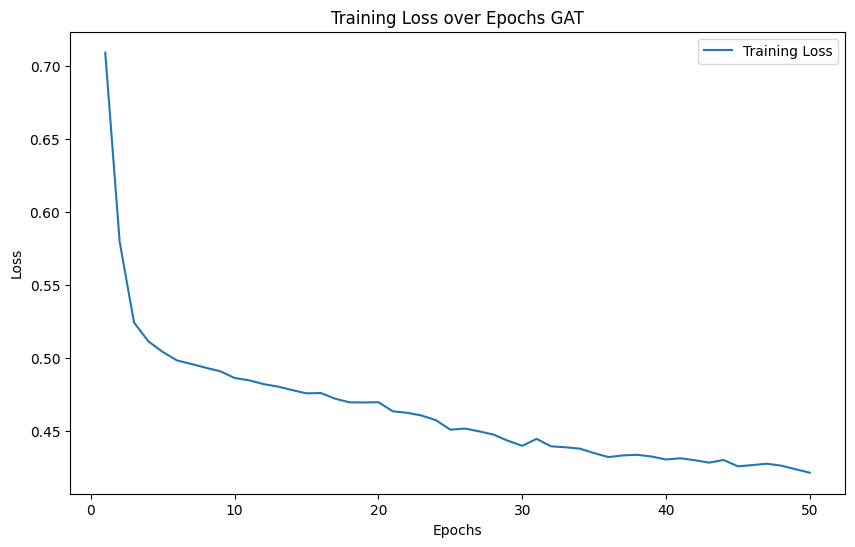

              precision    recall  f1-score   support

           0       0.96      0.64      0.77      1666
           1       0.42      0.91      0.58       479

    accuracy                           0.70      2145
   macro avg       0.69      0.78      0.68      2145
weighted avg       0.84      0.70      0.73      2145



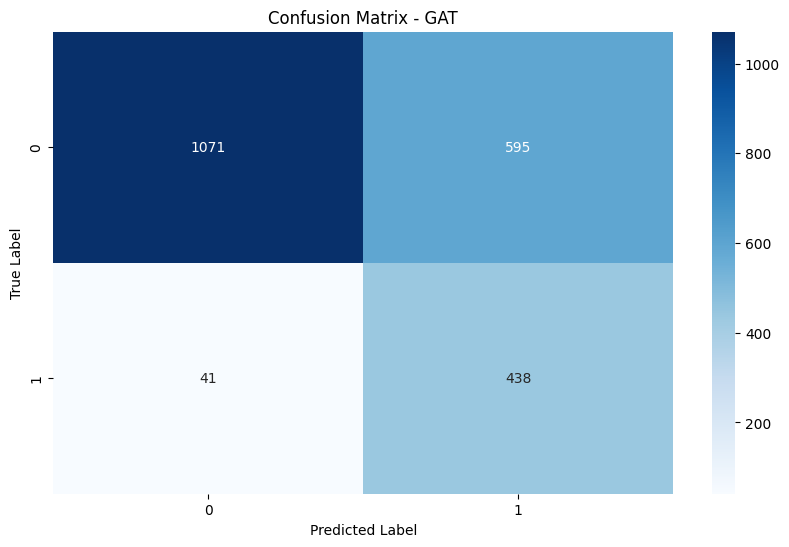

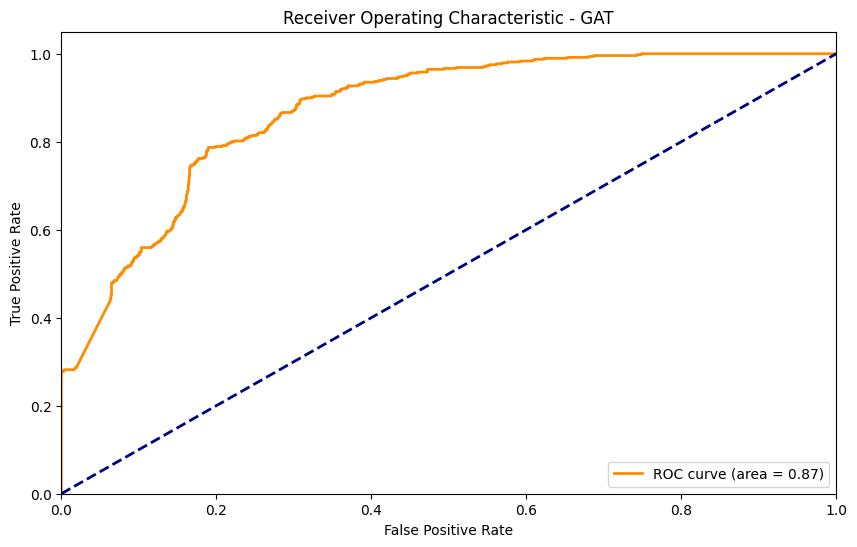

Inside train model with class weights
Epoch 1, Loss: 0.9133791161584668
Epoch 2, Loss: 0.3139783005145463
Epoch 3, Loss: 0.23928310569714417
Epoch 4, Loss: 0.2122788271782073
Epoch 5, Loss: 0.19304863888431678
Epoch 6, Loss: 0.1788250429725105
Epoch 7, Loss: 0.17531065676699986
Epoch 8, Loss: 0.1684481056661091
Epoch 9, Loss: 0.1551984469829635
Epoch 10, Loss: 0.14751642976294865
Epoch 11, Loss: 0.14842727831141514
Epoch 12, Loss: 0.14324023693122648
Epoch 13, Loss: 0.138277009468187
Epoch 14, Loss: 0.13828197261318564
Epoch 15, Loss: 0.13714992585168642
Epoch 16, Loss: 0.13470486555756492
Epoch 17, Loss: 0.12609303814613007
Epoch 18, Loss: 0.12219121683896943
Epoch 19, Loss: 0.1164204611188986
Epoch 20, Loss: 0.11972304319285533
Epoch 21, Loss: 0.11586315261030738
Epoch 22, Loss: 0.11680490362711927
Epoch 23, Loss: 0.10645853861404414
Epoch 24, Loss: 0.11290832395157353
Epoch 25, Loss: 0.10881406354548578
Epoch 26, Loss: 0.10609428865030747
Epoch 27, Loss: 0.10635128860700536
Epoch 28

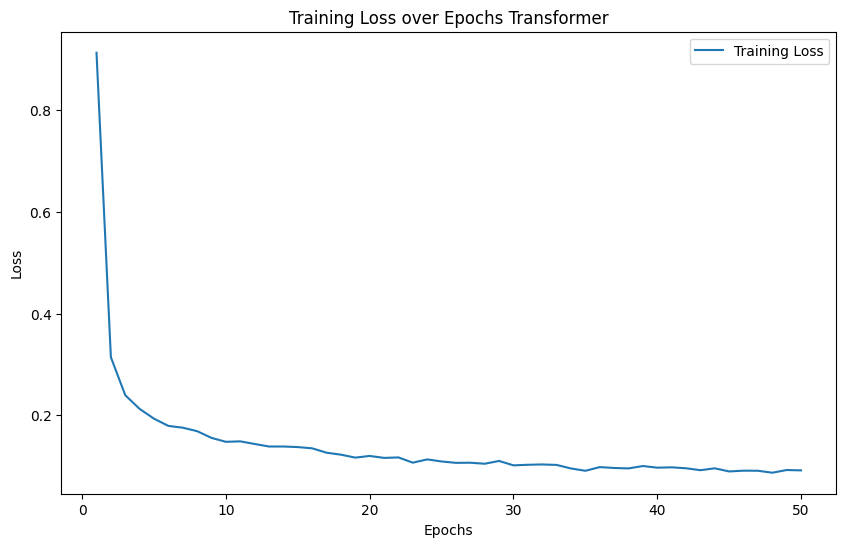

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1666
           1       0.84      0.99      0.91       479

    accuracy                           0.96      2145
   macro avg       0.92      0.97      0.94      2145
weighted avg       0.96      0.96      0.96      2145



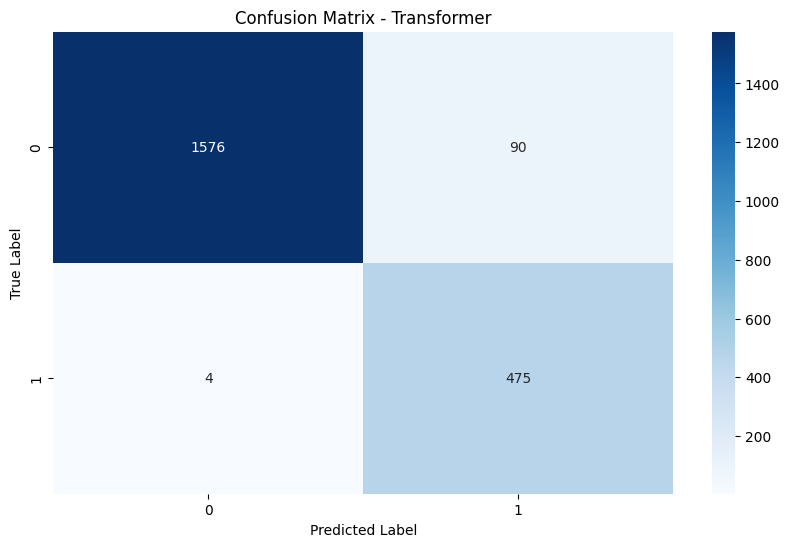

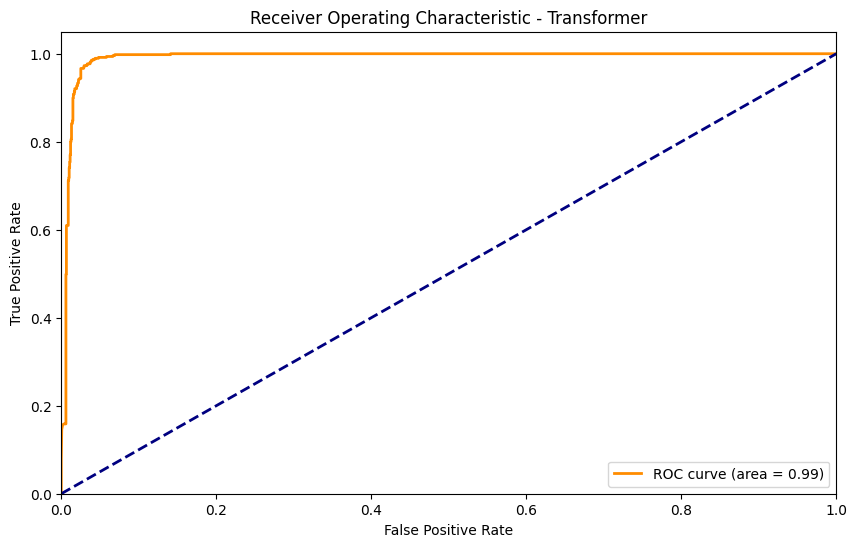

Inside train model with class weights
Epoch 1, Loss: 0.7582141005180099
Epoch 2, Loss: 0.6332842233506116
Epoch 3, Loss: 0.565044716000557
Epoch 4, Loss: 0.5411599535833705
Epoch 5, Loss: 0.5333523580973799
Epoch 6, Loss: 0.5260821845043789
Epoch 7, Loss: 0.5175130089575594
Epoch 8, Loss: 0.5132980434732004
Epoch 9, Loss: 0.510054851797494
Epoch 10, Loss: 0.5067569803107869
Epoch 11, Loss: 0.5025696862827648
Epoch 12, Loss: 0.4981283592906865
Epoch 13, Loss: 0.49546114287593146
Epoch 14, Loss: 0.4914824911816554
Epoch 15, Loss: 0.4885299707000906
Epoch 16, Loss: 0.4846473999998786
Epoch 17, Loss: 0.4779358726333488
Epoch 18, Loss: 0.478080117567019
Epoch 19, Loss: 0.476107523183931
Epoch 20, Loss: 0.47338966449553316
Epoch 21, Loss: 0.4723602225157348
Epoch 22, Loss: 0.4660480882633816
Epoch 23, Loss: 0.4643379951065237
Epoch 24, Loss: 0.4658168781210076
Epoch 25, Loss: 0.4615324745801362
Epoch 26, Loss: 0.46250249953432515
Epoch 27, Loss: 0.4592041346159848
Epoch 28, Loss: 0.455407111

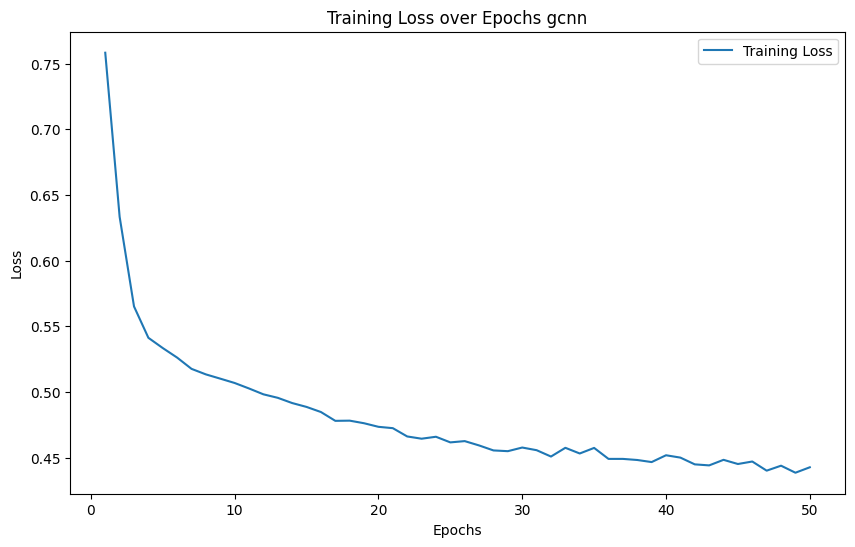

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1666
           1       0.49      0.83      0.62       479

    accuracy                           0.77      2145
   macro avg       0.72      0.79      0.73      2145
weighted avg       0.84      0.77      0.79      2145



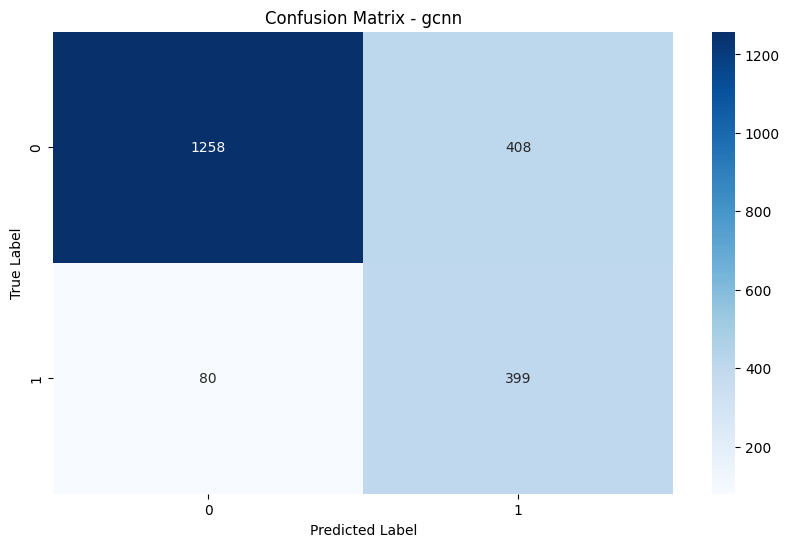

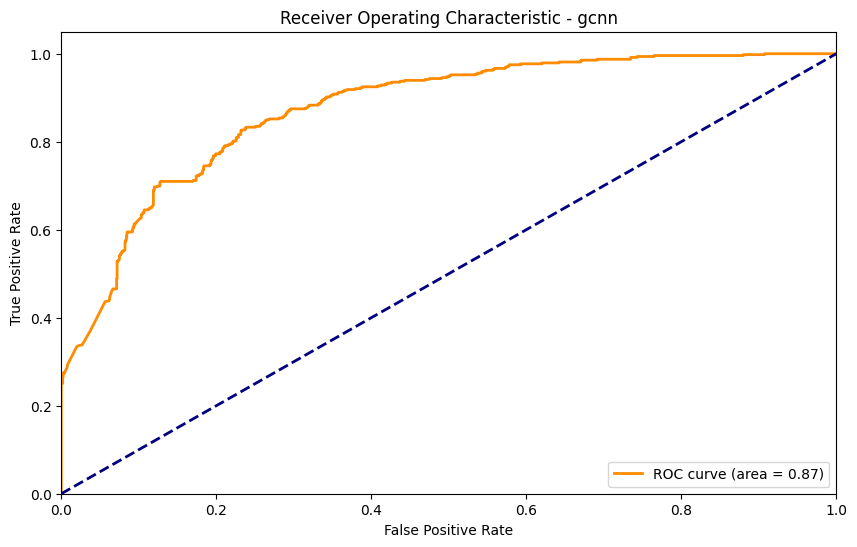

{'type10_label': {'GSageConv': 0.8977443609022556, 'GAT': 0.9377443609022557, 'GTransformer': 0.9058646616541354, 'GCNN': 0.9473684210526315}, 'type1_label_': {'GSageConv': 0.967623701893708, 'GAT': 0.8411728772144166, 'GTransformer': 0.9737324373854612, 'GCNN': 0.8827122785583384}, 'type2_label_': {'GSageConv': 0.9979859013091642, 'GAT': 0.9959718026183283, 'GTransformer': 0.9969788519637462, 'GCNN': 0.9969788519637462}, 'type3_label_': {'GSageConv': 0.9547785547785548, 'GAT': 0.7034965034965035, 'GTransformer': 0.9561771561771562, 'GCNN': 0.7724941724941725}}
type4_label_


100%|██████████| 1334/1334 [00:21<00:00, 61.06it/s]
c:\Users\Reek\anaconda3\envs\uavcan_v4\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


train_data:933
test_data:401
Inside train model with class weights


RuntimeError: weight tensor should be defined either for all 2 classes or no classes but got weight tensor of shape: [1]

In [19]:
import random
from torch.utils.data import random_split


new_execution_flag = 1
# assign_value()
if new_execution_flag == 1:
    current_time = time.localtime()
    folder_name = time.strftime("%Y-%m-%d_%H-%M-%S", current_time)
else:
    folder_name = input("Input folder name from all_execution_data")

result_dict = {}
for file_path in xlsx_files:
    

    if new_execution_flag == 1:
        data = pd.read_excel(file_path)
        data['can_id'] = data['can_id'].astype(str)
    
    label_key = os.path.basename(file_path).split('.')[0][0:12]
    print(label_key)

    output_dir = f"all_execution_data/{folder_name}/{label_key}/graphs"
    visualization_dir = os.path.join(f"all_execution_data/{folder_name}/{label_key}", "visualizations")
    result_dir =  os.path.join(f"all_execution_data/{folder_name}/{label_key}", "results")

    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(visualization_dir, exist_ok=True)
    os.makedirs(result_dir, exist_ok=True)
    
    if new_execution_flag == 1:
        pyg_data_list = preprocess_data_density(data,output_dir,visualization_dir)
    else:
        pyg_data_list = load_saved_graphs(output_dir)

    # train_size = int(0.7 * len(pyg_data_list))
    # test_size = len(pyg_data_list) - train_size
    # train_data, test_data = random_split(pyg_data_list, [train_size, test_size])

    # print(f"train_data: {len(train_data)}\ntest_data: {len(test_data)}")


    train_size = int(0.7 * len(pyg_data_list))
    train_data = pyg_data_list[:train_size]
    test_data = pyg_data_list[train_size:]

    # # Assuming pyg_graphs is your dataset and you have split it into train and test
    # train_size = int(0.8 * len(pyg_graphs))
    # test_size = len(pyg_graphs) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(pyg_graphs, [train_size, test_size])


    print(f"train_data:{len(train_data)}\ntest_data:{len(test_data)}")

    train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

    _,_,acc = run_SageConv(train_loader,test_loader,'SageConv',result_dir,visualization_dir)
    _,_,gat_acc = run_GAT(train_loader,test_loader,'GAT',result_dir,visualization_dir)
    _,_,transformer_acc = run_GTransformer(train_loader,test_loader,'Transformer',result_dir,visualization_dir)
    # _,_,sageConv_lstm_acc =run_SageConv_lstm(train_loader,test_loader,'sageConv_lstm',result_dir,visualization_dir)
    _,_,gcnn_acc =run_GCnn(train_loader,test_loader,'gcnn',result_dir,visualization_dir)

    result_dict[label_key] = {
        'GSageConv': acc,
        'GAT': gat_acc,
        'GTransformer': transformer_acc,
        # 'GSage_conv_lstm': sageConv_lstm_acc,
        'GCNN': gcnn_acc
    }

    print(result_dict)



# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")



In [ ]:
# result_dict

In [ ]:
results_df

,GSageConv,GAT,GTransformer,GCNN
type10_label,0.907714,0.856992,0.911589,0.855583
type1_label_,0.991662,0.886242,0.991066,0.876117
type2_label_,0.985451,0.983511,0.993695,0.989816
type3_label_,0.987722,0.828959,0.987299,0.858594
type4_label_,0.996119,0.990513,0.995257,0.990944
type5_label_,0.845827,0.849755,0.866121,0.871031
type6_label_,0.919041,0.793447,0.938272,0.880579
type7_label_,0.909677,0.762988,0.905263,0.848557
type8_label_,0.933549,0.916495,0.935019,0.889444
type9_label_,0.802011,0.697414,0.810920,0.772989


In [ ]:

# Create DataFrame
results_df = pd.DataFrame.from_dict(result_dict, orient='index')

# Save the DataFrame to a CSV file
time_str = str(time.time()).replace('.','_')
results_df.to_csv(f"all_execution_data/{folder_name}/results_analysis_{time_str}.csv")

In [ ]:
results_df